<a href="https://colab.research.google.com/github/mdubouch/noise-gan/blob/master/noise_info_per_particle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import sys
!{sys.executable} -m pip install uproot

     |████████████████████████████████| 122kB 3.3MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 


In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.cm as cm # colormaps
import matplotlib.colors as mcolors
import matplotlib.lines as lines
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = False
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['savefig.facecolor'] = 'white'

In [3]:
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/reconstructible_+evtid.root
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/chanmap_20180416.root

--2020-08-11 08:27:31--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/reconstructible_+evtid.root
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8422014 (8.0M)
Saving to: ‘reconstructible_+evtid.root’

reconstructible_+ev 100%[===================>]   8.03M  8.87MB/s    in 0.9s    

2020-08-11 08:27:32 (8.87 MB/s) - ‘reconstructible_+evtid.root’ saved [8422014/8422014]

--2020-08-11 08:27:35--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/chanmap_20180416.root
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809231 (1.7M)
Saving to: ‘chanmap_20180416.root’

chanmap_20180416.ro 100%[=======

In [4]:
file = uproot.open('reconstructible_+evtid.root')
n_pot = 247784700
n_bunches = n_pot / 16e6
print(n_bunches)

15.48654375


In [5]:
data = file['noise/noise'].array()

In [6]:
print(data.dtype)

[('edep', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8'), ('track_id', '<i4'), ('event_id', '<i4'), ('pid', '<i4'), ('wire', '<i4'), ('layer', '<i4')]


In [7]:
f_chanmap = uproot.open('chanmap_20180416.root')

In [8]:
chan_tree = f_chanmap['t']
chan_tree.keys()

[b'LayerLength',
 b'layer',
 b'wire',
 b'xhv',
 b'yhv',
 b'x0',
 b'y0',
 b'xro',
 b'yro',
 b'LayerID',
 b'isSenseWire',
 b'CellID',
 b'BoardID',
 b'BrdLayID',
 b'BrdLocID',
 b'ChanID']

In [9]:
xro = chan_tree['xro'].array()
yro = chan_tree['yro'].array()
map_layerid = chan_tree['LayerID'].array()
map_wire = chan_tree['wire'].array()

issense = chan_tree['isSenseWire'].array()

In [10]:
n_wires_per_layer = np.zeros(np.unique(map_layerid).size, dtype=int)
for l in np.unique(map_layerid):
    n_wires_per_layer[l] = map_wire[(map_layerid==l) * (issense==True)].size

In [11]:
n_wires_per_layer

array([198, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264,
       270, 276, 282, 288, 294, 300, 306])

In [12]:
cum_n_wires = np.concatenate([[0], np.cumsum(n_wires_per_layer)])
cum_n_wires

array([   0,  198,  396,  600,  810, 1026, 1248, 1476, 1710, 1950, 2196,
       2448, 2706, 2970, 3240, 3516, 3798, 4086, 4380, 4680, 4986])

In [13]:
def wire_abs_to_rel(wire_idx):
    layer = (wire_idx[:, np.newaxis] >= cum_n_wires).sum(axis=1) - 1
    wire = wire_idx - (cum_n_wires[layer])

    return (layer, wire)

In [14]:
# Validate wire IDs
assert(
    np.equal(wire_abs_to_rel(np.array([10, 198, 198+198, 198+198+204, 198+198+204-1])), 
             (np.array([0, 1, 2, 3, 2]), np.array([10, 0, 0, 0, 203]))).all()
)

In [15]:
# Define everything in terms of only sense wires

xro = chan_tree['xro'].array()
yro = chan_tree['yro'].array()
map_layerid = chan_tree['LayerID'].array()
map_wire = chan_tree['wire'].array()

issense = chan_tree['isSenseWire'].array()

xro = xro[issense==True]
yro = yro[issense==True]
map_layerid = map_layerid[issense==True]
map_wire = map_wire[issense==True]

In [16]:
def wire_rel_to_abs(layer_idx, wire_idx):
    return cum_n_wires[layer_idx] + wire_idx

map_wire_abs = wire_rel_to_abs(map_layerid, map_wire)
n_wires = np.unique(map_wire_abs).size
map_wire_abs[np.arange(0, n_wires)] = np.arange(0, n_wires)

def wire_pos(wire_abs_idx):
    cond = (wire_abs_idx[:, np.newaxis] == map_wire_abs)
    big_xro = np.tile(xro, (wire_abs_idx.size, 1))
    big_yro = np.tile(yro, (wire_abs_idx.size, 1))
    
    arr = (big_xro[cond], big_yro[cond])
    
    return arr

In [17]:
wire_x, wire_y = wire_pos(np.arange(0, map_wire_abs.size))

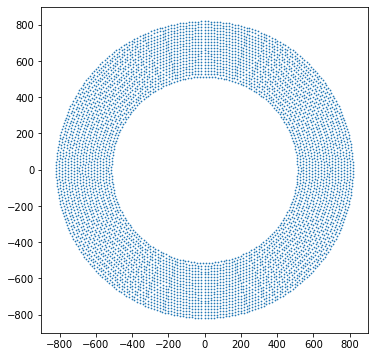

In [18]:
plt.figure(figsize=(6,6))
plt.scatter(wire_x, wire_y, s=0.5)
plt.gca().set_aspect(1)

In [19]:
data

array([(0.01191619, 7193.16255091, -763.41254326, 7549.49483199,  1416.28095527, 37280,     21464,       2212, 4020, 16),
       (0.00014032, 7190.34131922, -486.80340008, 8225.7937562 ,  3779.15449956, 38822,     51642, 1000060120, 3688, 15),
       (0.00924097, 7195.9837826 , -658.73725044, 8078.79043235,  2860.37782639, 38821,     51642,       2212, 4279, 17),
       ...,
       (0.00157046, 7148.02284385,  191.03450221, 8127.18111757,   109.94197987, 28495, 247731681,        -11,   87,  0),
       (0.00094848, 7148.02284385,  206.0782952 , 8120.87974712,   109.99881219, 28495, 247731681,        -11,   86,  0),
       (0.00015954, 7150.84407554, -293.57763385, 7208.73797704, 15135.91070224, 29738, 247734249,       2212,  377,  1)],
      dtype=[('edep', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8'), ('track_id', '<i4'), ('event_id', '<i4'), ('pid', '<i4'), ('wire', '<i4'), ('layer', '<i4')])

In [20]:
# Set up the data, throw away the invalid ones
wire = data['wire']
event_id = data['event_id']
layer = data['layer']
edep = data['edep']
t = data['t']
dbg_x = data['x']
dbg_y = data['y']
dbg_z = data['z']
track_id = data['track_id']
pid = data['pid']

data_orig = data.copy()

layer = layer[(wire>=0) * (edep>1e-6) * (edep < 1)]
event_id = event_id[(wire>=0) * (edep>1e-6) * (edep < 1)]
t = t[(wire>=0) * (edep>1e-6) * (edep < 1)]
dbg_x = dbg_x[(wire>=0) * (edep>1e-6) * (edep < 1)]
dbg_y = dbg_y[(wire>=0) * (edep>1e-6) * (edep < 1)]
dbg_z = dbg_z[(wire>=0) * (edep>1e-6) * (edep < 1)]
track_id = track_id[(wire>=0) * (edep>1e-6) * (edep < 1)]
pid = pid[(wire>=0) * (edep>1e-6) * (edep < 1)]
wire = wire[(wire>=0) * (edep>1e-6) * (edep < 1)]

edep = edep[(data['wire']>=0) * (edep>1e-6) * (edep < 1)]

print(wire.size, pid.size)

160193 160193


In [1133]:
# /!\ Careful memory hungry!
# Let's do it in two steps
wx, wy = wire_pos(wire[:data.size//2])
wx2, wy2 = wire_pos(wire[data.size//2:])
wx = np.concatenate([wx, wx2])
wy = np.concatenate([wy, wy2])

print(wx.size, wy.size, pid.size)

160193 160193 160193


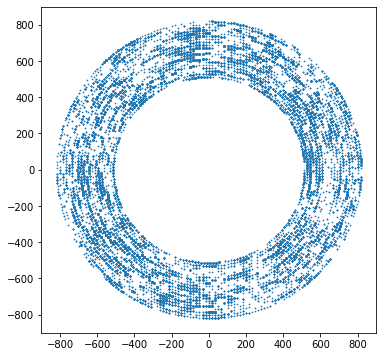

In [1134]:
plt.figure(figsize=(6,6))
plt.scatter(wx[:50000], wy[:50000], s=0.5);

In [ ]:
uq_tcks = 0
max_track_length = 0
for ev in np.unique(event_id):
    uq, counts = np.unique(track_id[event_id == ev], return_counts=True)
    uq_tcks += counts.size

    max_track_length = max(max_track_length, np.max(counts))
print(uq_tcks, max_track_length)

30720 1368


In [ ]:
t_wx = np.zeros((uq_tcks, max_track_length))
t_wy = np.zeros((uq_tcks, max_track_length))
t_edep = np.zeros((uq_tcks, max_track_length))
t_t = np.zeros((uq_tcks, max_track_length))
t_valid = np.zeros((uq_tcks, max_track_length))
_i = 0
for ev in np.unique(event_id):
    for tck in np.unique(track_id[event_id == ev]):
        tck_wx = wx[(event_id == ev) * (track_id == tck)]
        n_hits = tck_wx.size
        #print(i, t_wx[i,:n_hits].size, n_hits)
        t_wx[_i,:n_hits] = tck_wx
        t_wy[_i,:n_hits] = wy[(event_id == ev) * (track_id == tck)]
        t_edep[_i,:n_hits] = edep[(event_id == ev) * (track_id == tck)]
        t_t[_i,:n_hits] = t[(event_id == ev) * (track_id == tck)]
        t_valid[_i, :n_hits] = 1
        t_valid[_i, n_hits:] = -1
        _i += 1

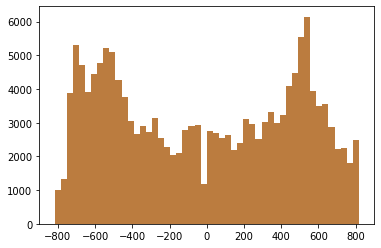

In [1135]:
plt.hist(t_wx[t_valid > 0].flatten(), bins=50);
plt.hist(wx, bins=50, alpha=0.7);

Draw the wire grid

In [1136]:
def grid_and_walls(ax):
    # Draw grid
    px, py = wire_pos(np.arange(0, map_wire_abs.size))
    ax.scatter(px, py, s=0.2, marker='.', edgecolors=None, c='gray', alpha=0.7)
    
    # Draw walls
    inner = Ellipse((0, 0), 488*2, 488*2, facecolor=(0, 0, 0, 0), edgecolor='gray')
    outer = Ellipse((0, 0), 846*2, 846*2, facecolor=(0, 0, 0, 0), edgecolor='gray')

    plt.gca().add_patch(inner)
    plt.gca().add_patch(outer);
    
    ax.set(xlim=(-900,900), ylim=(-900,900), xlabel='x [mm]', ylabel='y [mm]')
    
    
def only_walls(ax):
    # Draw walls
    inner = Ellipse((0, 0), 488*2, 488*2, facecolor=(0, 0, 0, 0), edgecolor='gray')
    outer = Ellipse((0, 0), 846*2, 846*2, facecolor=(0, 0, 0, 0), edgecolor='gray')

    plt.gca().add_patch(inner)
    plt.gca().add_patch(outer);
    
    ax.set(xlim=(-900,900), ylim=(-900,900), xlabel='x [mm]', ylabel='y [mm]')

## Check that debug position is identical to chanmap-translated ones

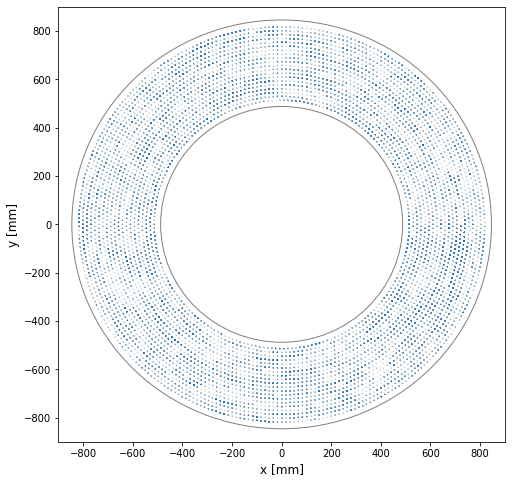

In [ ]:
plt.figure(figsize=(8, 8))
grid_and_walls(plt.gca())
plt.scatter(dbg_z-7650., dbg_y, s=edep, marker='.');

In [ ]:
wx

array([ 100.505168, -575.793756, -428.790432, ..., -477.181118,
       -470.879747,  441.262023])

In [ ]:
dbg_z-7650

array([-100.50516801,  575.7937562 ,  428.79043235, ...,  477.18111757,
        470.87974712, -441.26202296])

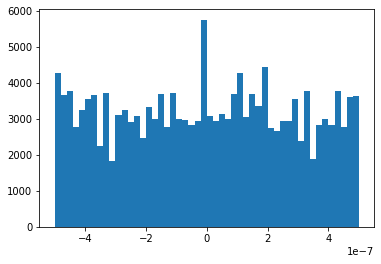

In [ ]:
plt.hist(-(dbg_z - 7650) - wx, bins=50);

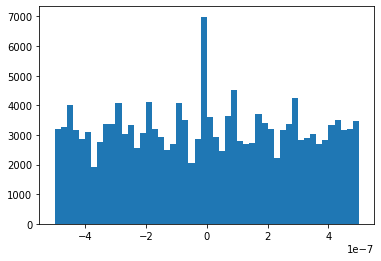

In [ ]:
plt.hist(dbg_y - wy, bins=50);

## Alright!

In [ ]:
pid[pid>2222] = 2212

In [ ]:
np.unique(pid)

array([ -11,   11,   22, 2212], dtype=int32)

In [ ]:
pid_d = np.zeros((pid.max() - pid.min() + 1), dtype=int)
for i, p in enumerate(np.unique(pid)):
    pid_d[p - pid.min()] = i

In [ ]:
np.unique(pid)

array([ -11,   11,   22, 2212], dtype=int32)

In [ ]:
pid_names = ['$e^+$', '$e^-$','$\gamma$', 'proton+ion']

In [ ]:
pid_dict = dict(zip(np.unique(pid), pid_names))
pid_dict

{-11: '$e^+$', 11: '$e^-$', 22: '$\\gamma$', 2212: 'proton+ion'}

In [ ]:
pid_d[np.unique(pid-pid.min())]

array([0, 1, 2, 3])

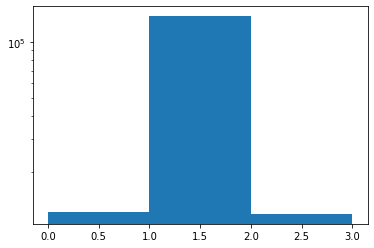

In [ ]:
plt.hist(pid_d[pid - pid.min()], bins=np.unique(pid).size-1);
plt.yscale('log')

In [ ]:
better_pid = pid_d[pid - pid.min()]
better_pid

array([3, 3, 3, ..., 0, 0, 3])

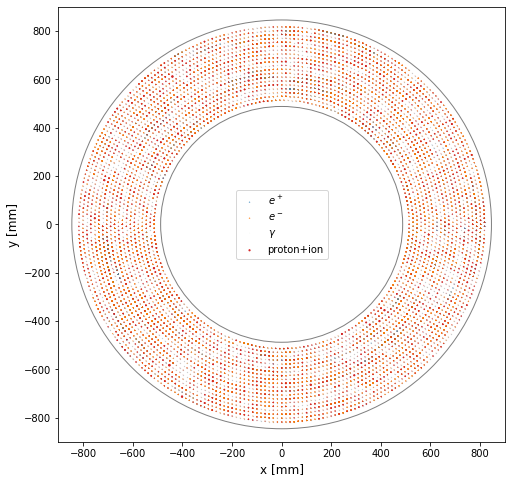

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
grid_and_walls(ax)

tab10 = cm.get_cmap('tab10')

for p in np.unique(pid):
    plt.scatter(wx[pid == p], wy[pid == p], 
                s=edep[pid==p], c=tab10(better_pid[pid == p]), cmap='tab10',
                label=pid_dict[p]);

plt.legend();
plt.savefig('all_noise.png', dpi=360)

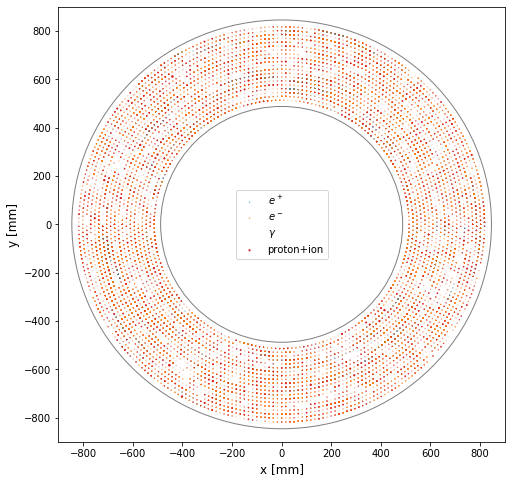

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
only_walls(ax)

tab10 = cm.get_cmap('tab10')

for p in np.unique(pid):
    plt.scatter(wx[pid == p], wy[pid == p], 
                s=edep[pid==p], c=tab10(better_pid[pid == p]), cmap='tab10',
                label=pid_dict[p]);

plt.legend();
plt.savefig('all_noise_p+i.png', dpi=120)

In [ ]:
# condition for first bunch
b0cond = (event_id < 16e6)
b0cond.sum()

11800

In [ ]:
print(11800 * 15, event_id.size)

177000 161570


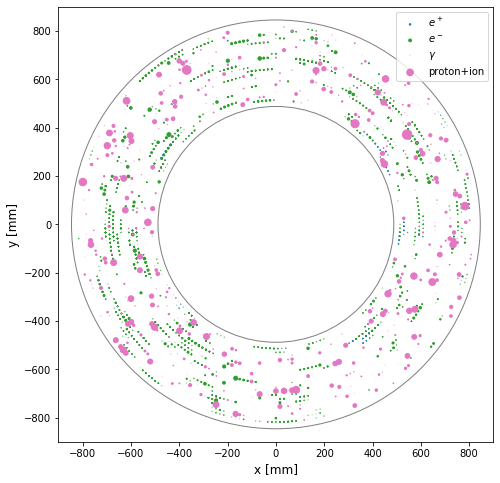

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
#grid_and_walls(ax)

tab20 = cm.get_cmap('tab20')

tab10 = cm.get_cmap('tab10')

b0wx = wx[b0cond]
b0wy = wy[b0cond]
b0pid = pid[b0cond]
b0edep = edep[b0cond]
b0better_pid = better_pid[b0cond]

ax.set_aspect(1)
only_walls(ax)
for p in np.unique(pid):
    plt.scatter(b0wx[b0pid == p], b0wy[b0pid == p], 
                s=b0edep[b0pid==p] * 100, c=tab20(b0better_pid[b0pid == p] * 4),#, cmap='tab10',
                label=pid_dict[p]);

plt.legend();

plt.savefig('noise_1_bunch.png', dpi=120)


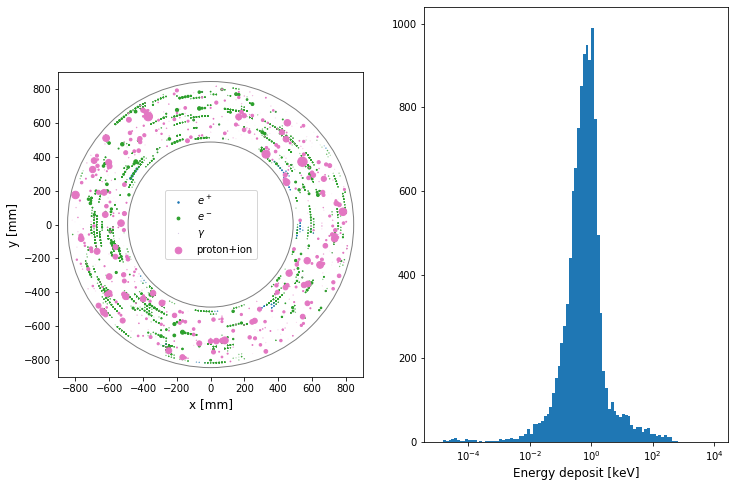

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.gca()
grid_and_walls(ax)

tab10 = cm.get_cmap('tab10')

b0wx = wx[b0cond]
b0wy = wy[b0cond]
b0pid = pid[b0cond]
b0edep = edep[b0cond]
b0better_pid = better_pid[b0cond]

ax = plt.subplot(121)
ax.set_aspect(1)
only_walls(ax)
for p in np.unique(pid):
    plt.scatter(b0wx[b0pid == p], b0wy[b0pid == p], 
                s=b0edep[b0pid==p] * 100, c=tab20(b0better_pid[b0pid == p] * 4), cmap='tab10',
                label=pid_dict[p]);

plt.legend();

plt.subplot(122)
bins = np.geomspace(1e-5, 1e4, 100) # keV
plt.hist(b0edep * 1e3, bins=bins);
plt.xlabel('Energy deposit [keV]')
plt.xscale('log')
#plt.savefig('all_noise.png', dpi=360)

In [ ]:
wx.size

161570

Next step: separate the energy deposits by track

This will give us very sparse data, which we need to deal with for the network.

In [ ]:
pairs = np.array([event_id, track_id])
np.unique(pairs, axis=1).shape

(2, 31990)

## Number of unique track/event pairs = number of unique objects

In [ ]:
print(np.unique(pairs, axis=1).shape[1])

31990


## Count the number of cousins that each hit has and add that as a feature

In [ ]:
# Define an absolute track id, not one that is dependent on event_id for unique identification

better_tid = np.zeros_like(track_id)
current = 0
total = 0
for ev in np.unique(event_id):
    tracks = track_id[event_id == ev]
    #print(tracks)
    uq, index, inverse, counts = np.unique(tracks, return_index=True, return_inverse=True, return_counts=True)
    total += counts.size
    #print(index, inverse, counts)
    better_tid[event_id == ev] = current + inverse
    #print(better_tid[event_id == ev])
    #print(inverse)
    #print(inverse.max(), current)
    #print(b_tid.shape, index.shape, inverse.shape)
    #print(inverse)
    current += inverse.max() + 1
    #print(current)

In [ ]:
print(total)

31990


In [ ]:
assert(total == np.unique(pairs, axis=1).shape[1])

In [ ]:
print(np.unique(better_tid).size)

31990


In [ ]:
assert(np.unique(better_tid).size == np.unique(pairs, axis=1).shape[1])

## Now we can more easily play with unique tracks and stuff

In [ ]:
uq, index, inverse, counts = np.unique(better_tid, return_index=True, return_inverse=True, return_counts=True)
ncousins = np.zeros_like(better_tid)
print(uq.shape, index.shape, inverse.shape, counts.shape)
#ncousins[inverse] = counts
ncousins = counts[inverse] - 1

(31990,) (31990,) (161570,) (31990,)


In [ ]:
np.exp(ncousins)

/home/md618/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([1.       , 1.       , 1.       , ..., 7.3890561, 7.3890561,
       1.       ])

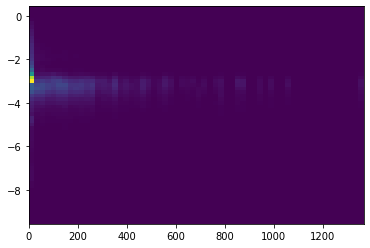

In [ ]:
plt.hist2d(ncousins, np.log10(edep), bins=60);

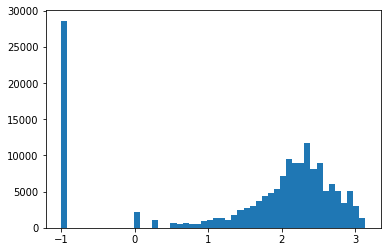

In [ ]:
plt.hist(np.log10(ncousins+0.1), bins=50);

## Devise way to estimate number of neighbors

For each wire (node), let's find the adjacent nodes

In [ ]:
wire_count = cum_n_wires[-1]

In [ ]:
# Let's start with wire 2000, and find the closest wires
thiswire = 4800
allwires = np.arange(0, wire_count)
thiswirex, thiswirey = wire_pos(np.array([thiswire]))

wirex, wirey = wire_pos(allwires)

dist = np.sqrt((wirex - thiswirex)**2 + (wirey - thiswirey)**2)

n neighbors: 6


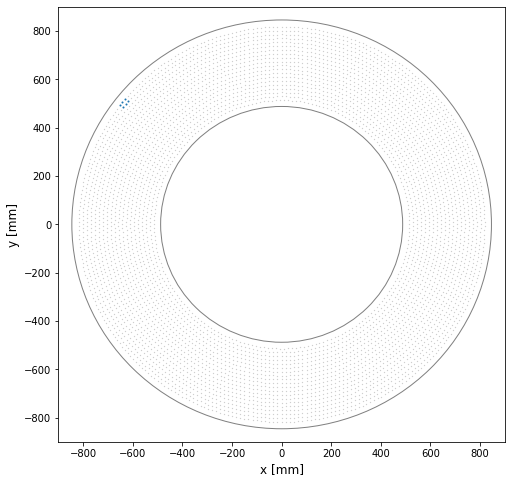

In [ ]:
plt.figure(figsize=(8,8))
print("n neighbors:", wirex[dist<30].size)
grid_and_walls(plt.gca())
plt.scatter(wirex[dist<30], wirey[dist<30], s=1);

Okay now for all wires

In [ ]:
wire.max()

4985

In [ ]:
print(allwires.max())

4985


In [ ]:
wire.max()

4985

In [ ]:
# Take 8 nearest neighbors for each wire
neighbors = np.zeros((wire_count, 8), dtype=int)

allwires = np.arange(0, wire_count)

wirex, wirey = wire_pos(allwires)

dist = 0
for thiswire in np.arange(0, wire_count):
    thiswirex, thiswirey = wire_pos(np.array([thiswire]))

    dist = np.sqrt((wirex - thiswirex)**2 + (wirey - thiswirey)**2)
    
    neighb = allwires[np.argsort(dist)][1:9]
    neighbors[thiswire] = neighb

def get_neighbors(wire):
    return neighbors[wire]

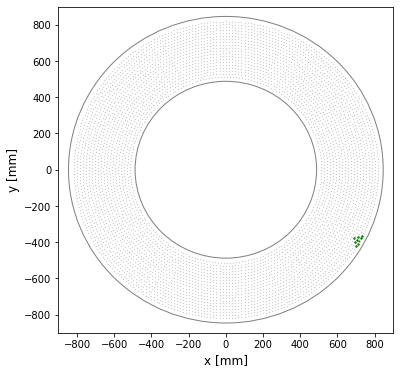

In [ ]:
plt.figure(figsize=(6,6))
grid_and_walls(plt.gca())
thiswire=wire_count-25
_posx, _posy = wire_pos(np.array([thiswire]))
plt.scatter(_posx, _posy, c='r', s=1);
_posx, _posy = wire_pos(get_neighbors(thiswire))
plt.scatter(_posx, _posy, c='g', s=2);

#### Looking good!

# Setup pytorch

160193


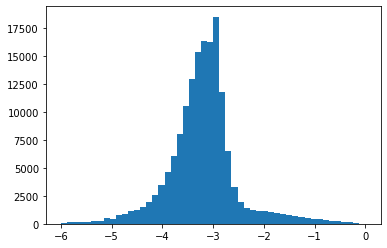

In [1138]:
plt.hist(np.log10(edep), bins=50)
print(edep.size)

In [1160]:
t_radius = np.sqrt(t_wx**2+t_wy**2)

t_theta = np.arctan2(t_wy, t_wx)
min_radius = t_radius[t_valid>0].min()
max_radius = t_radius[t_valid>0].max()

In [1161]:
def transform_pos(wx, wy):
    x_wx = (wx - min_radius * np.cos(t_theta)) / (max_radius - min_radius)
    x_wy = (wy - min_radius * np.sin(t_theta)) / (max_radius - min_radius)
    x_r = np.sqrt(x_wx**2 + x_wy**2)
    x_th = np.arctan2(x_wy, x_wx)
    return x_r, x_th

def inv_transform_pos(x_r, x_th):
    _wx = x_r * np.cos(x_th)
    _wy = x_r * np.sin(x_th)
    return _wx * (max_radius - min_radius) + min_radius * np.cos(x_th), _wy * (max_radius - min_radius) + min_radius * np.sin(x_th)

In [1162]:
t_x_r, t_x_th = transform_pos(t_wx, t_wy)

In [1163]:
t_x_r.shape

(30720, 1368)

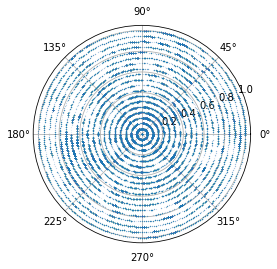

In [1164]:
#plt.figure(figsize=(8,8))
plt.polar(t_x_th[t_valid>0].flatten(), t_x_r[t_valid>0].flatten(), marker='.', markersize=0.1, linewidth=0);

In [1165]:
import torch
import torch.nn as nn
import torch.optim as optim

In [1166]:
print(torch.cuda.is_available())
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x

True


In [518]:
train = np.array([np.log10(edep), np.log10(t), x_r, x_th], dtype=np.float32)#, wire, layer], dtype=np.float32)

In [519]:
hit_group_size = 64

In [520]:
_train = torch.from_numpy(train)
_train.shape

torch.Size([4, 160193])

In [521]:
hit_group_stride = 1

In [522]:
_train = _train.unfold(1, hit_group_size, hit_group_stride)

In [523]:
_train.shape

torch.Size([4, 160130, 64])

In [524]:
_x_r_cm = _train.mean(axis=2)[2]
_x_th_cm = _train.mean(axis=2)[3]
#plt.figure(figsize=(6,6))
#plt.scatter(*inv_transform_pos(_x_r_cm.detach().cpu().numpy(), _x_th_cm.numpy()), s=1);

In [525]:
_x_r_cm_t = _x_r_cm.repeat(hit_group_size).reshape(hit_group_size, 1, -1).permute(1, 2, 0)
_x_th_cm_t = _x_th_cm.repeat(hit_group_size).reshape(hit_group_size, 1, -1).permute(1, 2, 0)

In [526]:
_x_r_cm_t.shape

torch.Size([1, 160130, 64])

In [527]:
_train.shape

torch.Size([4, 160130, 64])

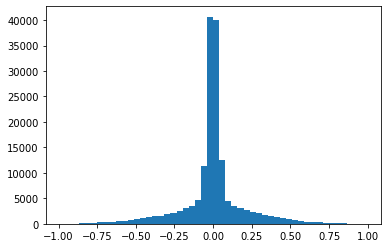

In [528]:
plt.hist((_train[2] - _x_r_cm_t[0])[:,0], bins=50);

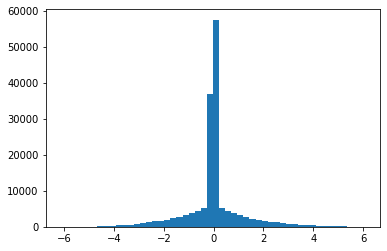

In [529]:
plt.hist((_train[3] - _x_th_cm_t[0])[:,0], bins=50);

In [530]:
_train = torch.cat([_train, _x_r_cm_t, _x_th_cm_t], dim=0)
_train[2] -= _train[4]
_train[3] -= _train[5]

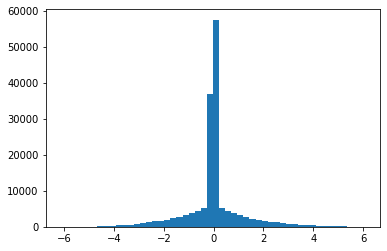

In [531]:
plt.hist(_train[3,:,0], bins=50);

In [532]:
# Alright, now _train has [E, t, r_dev, th_dev, r_cm, th_cm]
train = _train.numpy()

In [533]:
train_min = train[:,:,0].min(axis=1)
train_max = train[:,:,0].max(axis=1)

In [534]:
train_min, train_max

(array([-5.9975538e+00,  1.6348721e+00, -9.8437500e-01, -6.1384020e+00,
         6.3657274e-10, -3.1093352e+00], dtype=float32),
 array([-5.5493828e-04,  6.8692431e+00,  9.8437500e-01,  6.0818415e+00,
         1.0000000e+00,  3.0939929e+00], dtype=float32))

In [535]:
def pre_process(data):
    ret = np.zeros_like(data)
    ret = ((data.T - train_min) / (train_max - train_min) * 2 - 1).T
    return ret

print(train_min)
# Bound training set to [-1, 1]
train = pre_process(train)
print(train)

# Rotate and make into tensor
train = to_device(torch.from_numpy(train.T))

print(train.dtype, train.shape)
print(train.mean(axis=0), train.std(axis=0))

[-5.9975538e+00  1.6348721e+00 -9.8437500e-01 -6.1384020e+00
  6.3657274e-10 -3.1093352e+00]
[[[ 3.58576655e-01 -2.84753025e-01  3.21751475e-01 ... -2.74761319e-01
   -1.83710814e-01 -2.31178045e-01]
  [-2.84753025e-01  3.21751475e-01 -6.22673929e-01 ... -1.83710814e-01
   -2.31178045e-01 -3.47132742e-01]
  [ 3.21751475e-01 -6.22673929e-01 -3.04681659e-01 ... -2.31178045e-01
   -3.47132742e-01 -1.75567806e-01]
  ...
  [ 7.03481436e-02  6.62690401e-02  2.88411260e-01 ... -1.69081092e-02
    8.95690918e-03  6.50599003e-02]
  [ 6.62690401e-02  2.88411260e-01 -3.00134182e-01 ...  8.95690918e-03
    6.50599003e-02 -7.97671080e-03]
  [ 2.88411260e-01 -3.00134182e-01 -2.72677362e-01 ...  6.50599003e-02
   -7.97671080e-03 -2.66157627e-01]]

 [[-4.20645833e-01 -2.57781863e-01 -3.04003716e-01 ... -5.86480081e-01
   -5.86471558e-01 -5.86465955e-01]
  [-2.57781863e-01 -3.04003716e-01 -5.86936295e-01 ... -5.86471558e-01
   -5.86465955e-01 -5.86461425e-01]
  [-3.04003716e-01 -5.86936295e-01 -5.86944

In [536]:
train_min, train_max

(array([-5.9975538e+00,  1.6348721e+00, -9.8437500e-01, -6.1384020e+00,
         6.3657274e-10, -3.1093352e+00], dtype=float32),
 array([-5.5493828e-04,  6.8692431e+00,  9.8437500e-01,  6.0818415e+00,
         1.0000000e+00,  3.0939929e+00], dtype=float32))

In [538]:
def inv_transform(tensor):
    array = tensor.cpu().detach().numpy()

    array = (array + 1) / 2 # Put in range [0, 1]
    array = (array.T * (train_max - train_min) + train_min).T # Invert transformation

    #print(array.shape)
    array[2], array[3] = inv_transform_pos((array[2] + array[4]) % (1 + 1e-5), (array[3] + array[5] - (-np.pi)) % (2*np.pi + 1e-5) + (-np.pi))
    array[4], array[5] = inv_transform_pos(array[4], array[5])
    #array[2], array[3] = inv_transform_pos(array[2], array[3])
    return array

In [539]:
train.shape

torch.Size([64, 160130, 6])

In [540]:
#chunked = train.unfold(0, hit_group_size, 2).permute(1, 2, 0)
chunked = train.permute(2, 0, 1)

In [541]:
chunked.shape

torch.Size([6, 64, 160130])

In [542]:
print(chunked.shape, chunked.device)

torch.Size([6, 64, 160130]) cuda:0


In [543]:
_inv = inv_transform(chunked[:,0,:])

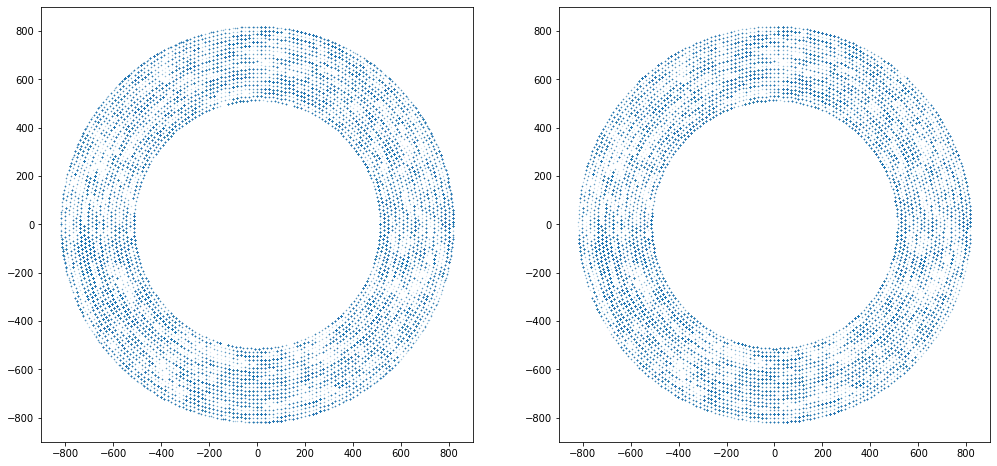

In [544]:
plt.figure(figsize=(17,8))
rainbow = cm.get_cmap('bone')
plt.subplot(121)
plt.scatter(_inv[2], _inv[3], s=0.1, alpha=0.2)#c=rainbow(np.arange(0, _inv[0].size) / _inv[0].size), alpha=0.8)
plt.subplot(122)
plt.scatter(wx[:], wy[:], s=0.1, alpha=0.2)

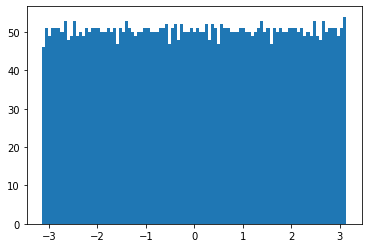

In [545]:
plt.hist(np.arctan2(wire_y, wire_x), bins=99);

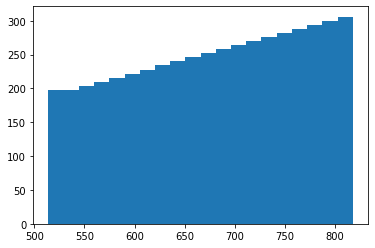

In [546]:
plt.hist(np.sqrt(wire_x**2 + wire_y**2), bins=20);

So the angular wire distribution is definitely flat in large-enough bins (99 is good number). The radial distribution is monotonically increasing with R, but does not have other features.

---

In [547]:
train.shape, chunked.shape

(torch.Size([64, 160130, 6]), torch.Size([6, 64, 160130]))

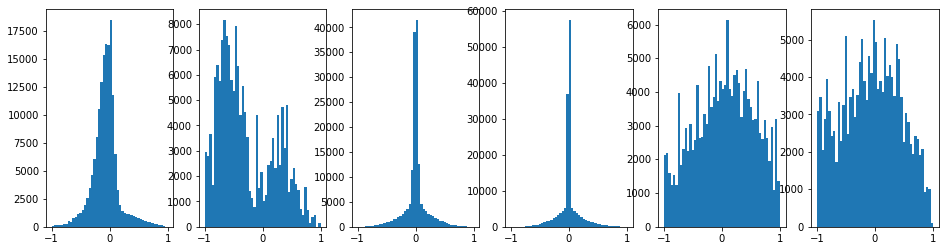

In [548]:
plt.figure(figsize=(16,4))
for i in range(train.shape[2]):
    plt.subplot(1, train.shape[2], i+1)
    plt.hist(chunked[i,0].flatten().cpu().detach().numpy(), bins=50);

In [400]:
nn.ConvTranspose1d(64, 64, 4, 1, 0)(torch.randn(16, 64, 1)).shape

torch.Size([16, 64, 4])

In [181]:
nn.Conv1d(64, 64, 5, 1, 0)(torch.randn(16, 64, 5)).shape

torch.Size([16, 64, 1])

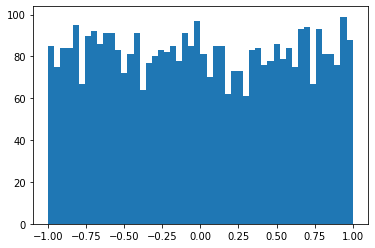

In [182]:
plt.hist(torch.rand(16, 64, 4).flatten() * 2 - 1, bins=50);

In [549]:
class PixelwiseNorm(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        return x# / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.eps)

class MBStdDev(nn.Module):
    # Minibatch Standard Deviation
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # std dev over minibatch
        std = torch.std(x, dim=0)
        avg = std.mean()
        batch_std_dev = avg.repeat(x.shape[0], 1, x.shape[2])

        out = torch.cat((x, batch_std_dev), dim=1)
        return out


class SeqPosStdDev(nn.Module):
    # Sequence Standard Deviation of average position features (4, 5)
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # Std dev over sequence
        seq_std = torch.std(x, dim=2)

        # Extract r, theta averages over
        seq_r_std_avg = seq_std[2].mean()
        seq_th_std_avg = seq_std[3].mean()
        seq_r_std_diff = seq_std[4].mean()
        seq_th_std_diff = seq_std[5].mean()
        
        seq_r_std_dev = seq_r_std_avg.repeat(x.shape[0], 1, x.shape[2])
        seq_th_std_dev = seq_th_std_avg.repeat(x.shape[0], 1, x.shape[2])
        seq_r_std_diff_dev = seq_r_std_diff.repeat(x.shape[0], 1, x.shape[2])
        seq_th_std_diff_dev = seq_th_std_diff.repeat(x.shape[0], 1, x.shape[2])

        #out = torch.cat((x, seq_r_std_dev, seq_th_std_dev, seq_r_std_diff_dev, seq_th_std_diff_dev), dim=1)
        out = torch.cat((x, seq_r_std_dev, seq_th_std_dev), dim=1)
        return out



class ConvEQ(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight.data = torch.randn_like(self.weight)
        self.bias.data = torch.zeros_like(self.bias)

        # Per-layer scale is kernel_size**2 *
        n = self.weight.shape[2] ** 2 * self.weight.shape[0]
        self.scale = np.sqrt(2 / n)


    def forward(self, x):
        out = nn.functional.conv1d(x, self.weight * self.scale, self.bias, self.stride, self.padding, dilation=self.dilation)
        return out

class ConvTransposeEQ(nn.ConvTranspose1d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight.data = torch.randn_like(self.weight)
        self.bias.data = torch.zeros_like(self.bias)

        # Per-layer scale is kernel_size**2 *
        n = self.weight.shape[2] ** 2 * self.weight.shape[0]
        self.scale = np.sqrt(2 / n)

    def forward(self, x):
        out = nn.functional.conv_transpose1d(x, self.weight * self.scale, self.bias, self.stride, self.padding, dilation=self.dilation)
        return out



class GenPosCorrection(nn.Module):
    # Sequence Standard Deviation of average position features (4, 5)
    def __init__(self):
        super().__init__()

    def forward(self, x): # x must be (B, n_features, 256)
        # Extract r, theta averages over
        seq_r_avg = x[:,4].mean(axis=1)
        seq_th_avg = x[:,5].mean(axis=1)

        #print(x[:,4].shape, seq_r_avg.shape)
        diff_r = (x[:,4].T - seq_r_avg).T
        diff_th = (x[:,5].T - seq_th_avg).T
        #print(diff_r.shape)

        diff = torch.zeros_like(x)
        diff[:,4] = diff_r
        diff[:,5] = diff_th
        #print(diff)

        #out = torch.cat((x, seq_r_std_dev, seq_th_std_dev), dim=1)
        #print(diff)
        return x - diff * 0.9

In [550]:
GenPosCorrection()(torch.randn(1, 6, 4))

tensor([[[ 0.5015, -0.5181, -0.1400,  1.9673],
         [-0.9129,  0.1012, -0.0594, -0.5933],
         [ 1.2928, -1.5014,  0.4733,  0.2840],
         [ 0.9605, -0.4349, -0.9482,  0.8221],
         [-0.4708, -0.4291, -0.6858, -0.6024],
         [-0.3084, -0.2476, -0.5202, -0.3135]]])

In [551]:
(ConvTransposeEQ(64, 64, 3, 2, 1, dilation=1)(torch.randn(16, 64, 125))).shape

torch.Size([16, 64, 249])

In [1070]:
n_features = chunked.shape[0]
seq_len = hit_group_size
input_dims = n_features * seq_len

#ndf = 24
#ngf = 16
ndf = 64
ngf = 64

latent_dims = 64 * 8

class Gen256Ups(nn.Module):
    def __init__(self):
        super().__init__()
        
        k = ngf
        self.k = k
        
        # Input: (B, latent_dims, 1)
        self.act = nn.LeakyReLU(0.2, True)

        #self.lin0 = nn.Linear(latent_dims, latent_dims * 4)

        # 1
        #self.conv4_1 = ConvTransposeEQ(latent_dims, k*8, 3, 1, 1)
        #self.conv4_2 = ConvTransposeEQ(k*8, k*8, 3, 1, 1, dilation=1)
        #self.bn0 = PixelwiseNorm()
        #self.bn4 = nn.BatchNorm1d(k*8, affine=True)#PixelwiseNorm()

        #self.upsx16 = nn.Upsample(scale_factor=16) # (, , 256)

        #self.conv16_1 = ConvTransposeEQ(k*8, k*4, 5, 1, 2)
        #self.conv16_2 = ConvTransposeEQ(k*4, k*4, 3, 1, 1, dilation=1)
        #self.bn16 = nn.BatchNorm1d(k*4, affine=True)#PixelwiseNorm()

        #self.upsx4 = nn.Upsample(scale_factor=4)

        #self.conv64_1 = ConvTransposeEQ(k*4, k*2, 15, 1, 7)
        #self.conv64_2 = ConvTransposeEQ(k*2, k*2, 3, 1, 1, dilation=1)
        #self.bn64 = nn.BatchNorm1d(k*2, affine=True)

        #self.lin0 = nn.Linear(latent_dims, 8 * k*4)
        self.bn0 = nn.Identity()#nn.BatchNorm1d(k*4)
        # (B, 64, 256)

        #self.conv256_1 = ConvTransposeEQ(k*4, k*16, 4, 2, 1, dilation=1)
        self.conv256_2 = ConvTransposeEQ(latent_dims // 8, k*4, 4, 2, 1, dilation=1)
        self.conv256_3 = ConvTransposeEQ(k*4, k*2, 4, 2, 1)
        self.conv256_4 = ConvTransposeEQ(k*2, k*1, 4, 2, 1, dilation=1)
        #self.conv256_5 = ConvTransposeEQ(k*2, k, 4, 2, 1, dilation=1)
        self.conv256_5 = ConvTransposeEQ(k, k, 3, 1, 1)
        #self.bn256_1 = nn.BatchNorm1d(k*4)
        self.bn256_2 = nn.BatchNorm1d(k*4)
        self.bn256_3 = nn.BatchNorm1d(k*2)
        self.bn256_4 = nn.BatchNorm1d(k*1)
        # self.bn256_5 = nn.BatchNorm1d(k*1)
        # self.bn256_1 = PixelwiseNorm()
        # self.bn256_2 = PixelwiseNorm()
        # self.bn256_3 = PixelwiseNorm()
        # self.bn256_4 = PixelwiseNorm()
        #self.bn256_5 = PixelwiseNorm()
        

        #self.lin7_2 = nn.Linear(270, 256)

        self.to256 = ConvTransposeEQ(k, n_features, 1, 1, 0)

        self.correct = GenPosCorrection()

        self.out = nn.Tanh()

        #self.id = nn.Identity()
        
    def forward(self, z, stage, alpha):
        # z: random point in latent space
        # stage: length of sequence returned by generator
        # alpha: blending factor (0 = upsampled image from previous layer; 1 = full image from new layer)
        
        #x0 = z.reshape(-1, latent_dims).repeat(256, 1, 1).permute(1, 2, 0)
        x0 = z.reshape(-1, latent_dims // 8, 8)
        #x0 = self.bn0(self.act(self.lin0(z.reshape(-1, latent_dims)).reshape(-1, self.k*4, 8)))

        #x4 = self.bn4(self.act(self.conv4_1(x4)))
        #x4 = self.bn1(self.act(self.conv1_2(self.act(self.conv1_1(z.reshape((-1, latent_dims, 1)))))))
        #x16 = self.bn16(self.act(self.conv16_1(self.upsx4(x4))))
        #x64 = self.bn64(self.act(self.conv64_2(
        #x64 = self.act(self.conv64_1(self.upsx4(x16)))
        #x256 = self.conv256_2(self.act(
        #x256 = self.act(self.conv256_4(self.act(self.conv256_3(self.act(self.conv256_2(self.act(self.conv256_1(self.upsx4(x64)))))))))
        
        #x256 = self.act(self.conv256_4(self.bn256_3(self.act(self.conv256_3(self.bn256_2(self.act(self.conv256_2(self.bn256_1(self.act(self.conv256_1(x0)))))))))))
        x256 = self.act(self.conv256_5(self.bn256_4(self.act(self.conv256_4(
            self.bn256_3(self.act(self.conv256_3(self.bn256_2(self.act(self.conv256_2(x0)))))))))))

        return self.out(self.correct(self.to256(x256)))
        #return self.out(self.to256(x256))

class Disc256Ups(nn.Module):
    def __init__(self):
        super().__init__()
        
        k = ndf
        self.k = k

        
        # (B, n_features, 256)
        self.act = nn.LeakyReLU(0.2, True)

        self.seq_std = SeqPosStdDev()

        #self.from256 = ConvEQ(n_features+4, k, 1, 1, 0)
        #self.from256 = ConvEQ(n_features, k, 1, 1, 0)

        #self.conv256_1 = ConvEQ(k*2, k*2, 3, 1, 1)
        #self.conv256_2 = ConvEQ(k*2, k*4, 3, 1, 1)
        self.conv256_1 = ConvEQ(n_features+2, k, 3, 1, 1)
        self.conv256_2 = ConvEQ(k, k, 5, 2, 2, dilation=1)
        self.conv256_3 = ConvEQ(k, k*2, 5, 2, 2, dilation=1)
        self.conv256_4 = ConvEQ(k*2, k*4, 5, 2, 2)
        #self.conv256_5 = ConvEQ(k*4, k*8, 5, 2, 2)
        #self.conv256_6 = ConvEQ(k*8, k*16, 5, 2, 2)
        #self.conv256_3 = ConvEQ(k*4, k*4, 31, 1, 15)
        #self.conv256_4 = ConvEQ(k*4, k*4, 63, 1, 31, dilation=1)

        # self.bn1 = nn.BatchNorm1d(k)
        # self.bn2 = nn.BatchNorm1d(k)
        # self.bn3 = nn.BatchNorm1d(k*2)
        # self.bn4 = nn.BatchNorm1d(k*4)
        # self.bn5 = nn.BatchNorm1d(k*4)

        self.bn1 = nn.Identity()
        self.bn2 = nn.Identity()
        self.bn3 = nn.Identity()
        self.bn4 = nn.Identity()
        self.bn5 = nn.Identity()
        

        self.mb_stddev = MBStdDev() # Adds a feature map -> (B, C + 1, L)

        #self.conv64_1 = ConvEQ(k*2, k*2, 3, 1, 1, dilation=1)
        #self.conv64_2 = ConvEQ(k*2, k*4, 15, 1, 7)

        #self.conv8_1 = ConvEQ(k*8+1, k*8, 4, 1, 0) # k*32, 1

        #self.poolx16 = nn.AvgPool1d(16)
        #self.poolx4 = nn.AvgPool1d(4)

        #self.conv16_1 = ConvEQ(k*4, k*4, 3, 1, 1, dilation=1)
        #self.conv16_2 = ConvEQ(k*4, k*8, 5, 1, 2)

        #self.conv4_1 = ConvEQ(k*8, k*8, 3, 1, 1)

        #self.conv1_1 = ConvEQ(k*8, k*8, 3, 1, 1, dilation=1)
        #self.conv1_2 = ConvEQ(k*8+1, 1, 3, 1, 1)
        
        #self.lin1_1 = nn.Linear((k*8+1) * 4, k*4)
        self.lin1_1 = nn.Linear((k*4+1)*8, 1)
        
        self.out = nn.Identity()
    
    def forward(self, x_, alpha): # x shape is (batch, features, seq_len)
        stage = x_.shape[2]
        
        #x0 = self.act(self.from256(self.seq_std(x_)))
        #x1 = self.conv1_5(self.act(self.conv1_4(self.act(self.conv1_3(self.act(self.conv1_2(self.act(self.conv1_1(x0)))))))))
        #x1 = self.conv1_9(self.act(self.conv1_8(self.act(self.conv1_7(self.act(self.conv1_6(x1)))))))

        #x256 = self.act(self.conv256_4(self.act(self.conv256_3(self.act(self.conv256_2(self.act(self.conv256_1(x0))))))))
            #self.act(self.conv256_1(x0))))
        
        #x256 = self.act(self.conv256_4(self.act(self.conv256_3(self.act(self.conv256_2(self.act(self.conv256_1(x0))))))))
        x256 = self.conv256_4(
            self.bn3(self.act(self.conv256_3(self.bn2(self.act(self.conv256_2(self.bn1(self.act(self.conv256_1(self.seq_std(x_)))))))))))
        x1 = self.lin1_1(self.mb_stddev(x256).flatten(1, 2))

        #x64 = self.act(self.conv64_2(self.poolx4(x256)))
            #self.act(self.conv64_1(self.poolx4(x256)))))
        
        #x16 = self.act(self.conv16_2(self.poolx4(x64)))
            #self.act(self.conv16_1(self.poolx4(x64)))))

        #x1 = self.conv1_2(self.act(self.mb_stddev(self.conv1_1(self.poolx16(x16)))))
        #x4 = self.act(self.conv4_1(self.poolx4(x16)))

        #concat = torch.cat([x4, x16, x64, x256], dim=1)

        #x1 = self.lin1_1(x4.flatten(1, 2))
        #x1 = self.lin1_2(self.act(self.lin1_1(self.mb_stddev(x4).flatten(1, 2))))

        #x = self.poolx64(x)

        #x = self.lin(x.flatten(1, 2))
        
        return self.out(x1.squeeze())
            
        
gen = to_device(Gen256Ups())
disc = to_device(Disc256Ups())

In [1071]:
def get_n_params(model):
    return sum(p.reshape(-1).shape[0] for p in model.parameters())

print('generator params:', get_n_params(gen))
print('discriminator params:', get_n_params(disc))

generator params: 243462
discriminator params: 229385


In [1072]:
# Sample `batch_size` vectors from the real distribution

def sample_real(batch_size, stage, noise_strength=0.01):
    ids = np.random.choice(chunked.shape[2], size=batch_size)
    smpl = chunked[:,:,ids].permute(2, 0, 1)

    #smpl = nn.functional.avg_pool1d(smpl, kernel_size=256//stage)
    
    _noise = noise_strength * torch.randn_like(smpl)
    return torch.clamp(smpl + _noise, -1, 1)#periodic(smpl + _noise, [2, 3, 4])

def sample_fake(batch_size, stage, alpha):
    noise = to_device(torch.randn((batch_size, latent_dims, 1)))
    _fk = gen(noise, stage, alpha)
    return _fk

In [1073]:
batch_size=64

In [1074]:
discriminator_losses = []
generator_losses = []
gen_conv9_grad = []
disc_lin_grad = []
gen_conv9_w = []
disc_lin_w = []
gen_conv9_s = []
disc_lin_s = []

In [1075]:
sample_real(16, 256).shape

torch.Size([16, 6, 64])

In [1076]:
sample_fake(16, 256, 1).shape

torch.Size([16, 6, 64])

In [1077]:
print(gen)
print(disc)
print(disc(sample_real(16, 256), 256).shape)
print(disc(sample_fake(16, 256, 1), 256).shape)

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (bn0): Identity()
  (conv256_2): ConvTransposeEQ(64, 256, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv256_3): ConvTransposeEQ(256, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv256_4): ConvTransposeEQ(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv256_5): ConvTransposeEQ(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn256_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256_3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn256_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (to256): ConvTransposeEQ(64, 6, kernel_size=(1,), stride=(1,))
  (correct): GenPosCorrection()
  (out): Tanh()
)
Disc256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (seq_std): SeqPosStdDev()
  (conv256_1): ConvEQ(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv256_2)

In [1078]:
#gen = Gen()
#disc = Disc()

optimizer_gen = \
    torch.optim.Adam(gen.parameters(),  lr=0.0001, betas=(0.5, 0.999))#, weight_decay=1e-5)
optimizer_disc = \
    torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))#, weight_decay=1e-5)
 
n_critic = 1
lambda_gp = 10
#noise_lvl = 0.02


In [1079]:
noise_lvl = 0.01

In [1080]:
import torch.autograd as autograd

# Implement "Gradient Penalty" for WGAN-GP (https://arxiv.org/pdf/1704.00028.pdf)
def gradient_penalty(disc, real, fake):
    eps = to_device(torch.rand((real.shape[0], 1, 1)))

    interpolates = (eps * real + (1-eps) * fake).requires_grad_(True)
    d_interpolates = disc(interpolates, real.shape[2])
    grad_outputs = to_device(torch.ones((real.shape[0]), requires_grad=False))


    gradients = autograd.grad(outputs=d_interpolates,
                              inputs=interpolates,
                              grad_outputs=grad_outputs,
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True
    )[0]
    gradients = gradients.view(gradients.shape[0], -1)
    gradient_pen = ((gradients.norm(2, dim=1) - 1)**2).mean()
    return gradient_pen

In [1081]:
alpha = 1.
state = 1
stage=256
its_since_prev_state = 0

alpha: 1
stage: 256
state: 1
d_loss: tensor(-0.4947, device='cuda:0', grad_fn=<AddBackward0>)
0 iterations remaining.
Samples seen: 384000   Epochs: 2
500 its: 22.5 seconds
Noise lvl: 0.0029198902433877237


<Figure size 432x288 with 0 Axes>

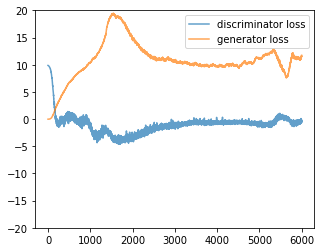

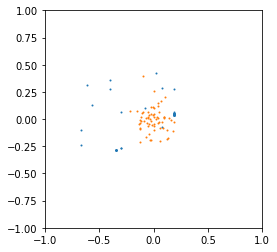

2000 iterations took 90.2 seconds


In [1101]:
from IPython.display import clear_output
import time

start_time = time.time()
last_time = time.time()

gen.train()
disc.train()

# State variable:
#   0: linearly increasing alpha to blend in higher resolution samples
#   1: alpha fixed at 1
#state = 0
#its_since_prev_state = 0
its_per_state = 2000

alpha_step = 1. / its_per_state

its_to_do = 2000


for i in range(its_to_do):
    
    if ((i+1) % 250 == 0):
        noise_lvl *= 0.95


    disc.train()
    gen.eval()

    # Discriminator's loss, based on two things:
    #  - Number of fake samples misidentified as real
    #  - Number of real samples misidentified as fake
    optimizer_disc.zero_grad()

    # Sample
    real = sample_real(batch_size, stage, 0)
    fake = sample_fake(batch_size, stage, alpha)
    
    true_disc_out = disc(real  + torch.randn_like(fake) * noise_lvl, alpha)
    #true_disc_loss = loss(true_disc_out, 0.9 + 0.1 * torch.rand((batch_size), device='cuda'))
     
    
    gen_disc_out = disc(fake.detach()  + torch.randn_like(fake) * noise_lvl, alpha)
    #gen_disc_loss = loss(gen_disc_out, 0.1 * torch.rand((batch_size), device='cuda'))
     
    gp = gradient_penalty(disc, real, fake)

    d_loss = -torch.mean(true_disc_out) + torch.mean(gen_disc_out) + lambda_gp * gp
    #d_loss = nn.functional.binary_cross_entropy(true_disc_out, torch.ones_like(true_disc_out)) + \
    #         nn.functional.binary_cross_entropy(gen_disc_out, torch.zeros_like(gen_disc_out))
    d_loss.backward()

    optimizer_disc.step()
      
    

    # Train gen, keep disc fixed
    optimizer_gen.zero_grad()
    
    gen.train()
    disc.eval()

    if i % n_critic == 0:
        fake = sample_fake(batch_size, stage, alpha)

        gen_disc_out = disc(fake + torch.randn_like(fake) * noise_lvl, alpha)
        g_loss = -torch.mean(gen_disc_out)
        #g_loss = nn.functional.binary_cross_entropy(gen_disc_out, torch.ones_like(gen_disc_out))

        g_loss.backward()
        optimizer_gen.step()

        discriminator_losses.append(d_loss.item())
        generator_losses.append(g_loss.item())
    
#         gen_conv9_w.append(torch.mean(gen.convf.weight).item())
#         gen_conv9_s.append(torch.std(gen.convf.weight).item())
#         disc_lin_w.append(torch.mean(disc.conv0.weight).item())
#         disc_lin_s.append(torch.std(disc.conv0.weight).item())
# #
#         gen_conv9_grad.append(torch.mean(gen.convf.weight.grad).item())
#         disc_lin_grad.append(torch.mean(disc.conv0.weight.grad).item())

    its_since_prev_state += 1


    if (state == 0):
        alpha += alpha_step
        if (alpha > 1.):
            alpha = 1.

    if its_since_prev_state == its_per_state:
        its_since_prev_state = 0
        if (state == 0):
            state = 1
            alpha = 1
        elif (state == 1):
            if (stage < 256):
                state = 0
                alpha = 0.
                stage *= 2
            else:
                alpha = 1
                state = 1



    # Display progress
    progress_rate = 500
    if (i+1) % progress_rate == 0:
        
        clear_output(wait=True)
        print("alpha:", alpha)
        print("stage:", stage)
        print("state:", state)
        print("d_loss:", d_loss)

        print(str(its_to_do - i - 1) + " iterations remaining.")
        print("Samples seen: " + str(len(discriminator_losses) * batch_size), 
              "  Epochs:", str(len(discriminator_losses) * batch_size // chunked.shape[2]))
        cur_time = time.time()
        elapsed = cur_time - last_time
        print("%d its: %.1f seconds" % (progress_rate, elapsed))

        print("Noise lvl:", noise_lvl)

        last_time = cur_time
        plt.clf()
        plt.figure(figsize=(5, 4))
        #plt.subplot(131)
        plt.plot(discriminator_losses, label='discriminator loss', alpha=0.7)
        plt.plot(generator_losses    , label='generator loss', alpha=0.7)
        plt.legend()
        plt.ylim(-20, 20)
        plt.show()

        # plt.subplot(132)
        # plt.fill_between(np.arange(len(disc_lin_w)), np.array(disc_lin_w) - disc_lin_s, np.array(disc_lin_w) + disc_lin_s, alpha=0.4)
        # plt.fill_between(np.arange(len(gen_conv9_w)), np.array(gen_conv9_w) - gen_conv9_s, np.array(gen_conv9_w) + gen_conv9_s, alpha=0.4)
        # plt.plot(disc_lin_w, label='disc last layer mean weight')
        # plt.plot(gen_conv9_w, label='gen last layer mean weight')
        # plt.legend()

        # plt.subplot(133)
        # plt.plot(disc_lin_grad, label='disc last layer mean grad')
        # plt.plot(gen_conv9_grad, label='gen last layer mean grad')
        # plt.legend()
        # plt.show()

        
        gen.eval()
        _real = sample_real(1, stage, 0).cpu().detach().numpy()
        _fake = sample_fake(1, stage, alpha).cpu().detach().numpy()
        #plt.polar((_real[:,3] + _fake[:,5]).cpu().detach().numpy().squeeze() * np.pi + np.pi, 
        #          (_real[:,2] + _real[:,4]).cpu().detach().numpy().squeeze() * 0.5 + 0.5, marker='.', linewidth=0)
        #plt.polar((_fake[:,3] + _fake[:,5]).cpu().detach().numpy().squeeze() * np.pi + np.pi, 
        #          (_fake[:,2] + _fake[:, 4]).cpu().detach().numpy().squeeze() * 0.5 + 0.5, marker='.', linewidth=0)
        plt.scatter(_real[:, 2], _real[:,3], s=1)
        plt.scatter(_fake[:, 2], _fake[:,3], s=1)
        
        plt.gca().set_aspect(1)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        #plt.yscale('log')
        #plt.legend()
        plt.show()
        
end_time = time.time()
elapsed = end_time - start_time

print("%d iterations took %.1f seconds" % (its_to_do, elapsed))

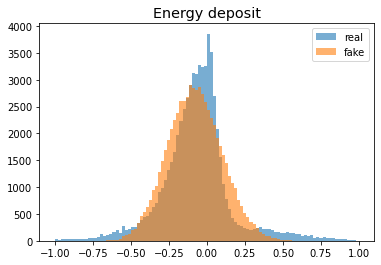

In [1087]:
gen.eval()
result_real = sample_real(1000, stage, noise_lvl)
result_fake = sample_fake(1000, stage, alpha)
plt.hist(result_real[:,0].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=False, range=[-1,1])
plt.hist(result_fake[:,0].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=False, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Energy deposit")
plt.show()

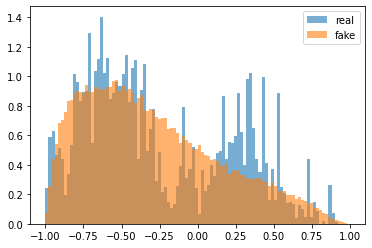

In [1088]:
plt.hist(result_real[:,1].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=True, range=[-1, 1])
plt.hist(result_fake[:,1].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=True, range=[-1, 1])

plt.legend()
plt.show()

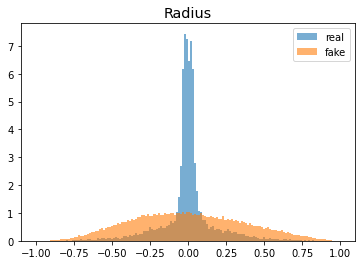

In [1085]:
plt.hist(result_real[:,2].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='real', density=True, range=[-1,1])
plt.hist(result_fake[:,2].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='fake', density=True, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Radius")
plt.show()

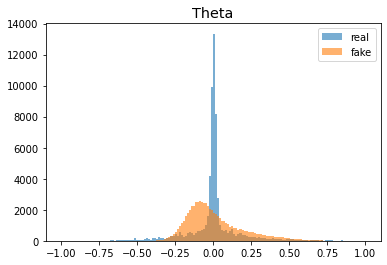

In [1069]:

plt.hist(result_real[:,3].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='real', density=False, range=[-1,1])
plt.hist(result_fake[:,3].flatten().cpu().detach().numpy(), bins=150, alpha=0.6, label='fake', density=False, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Theta")
plt.show()

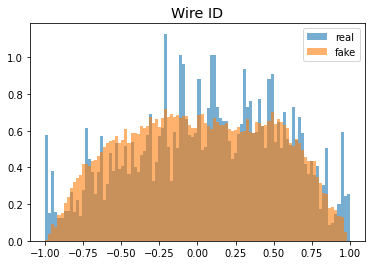

In [1017]:
plt.hist(result_real[:,4].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=True, range=[-1,1])
plt.hist(result_fake[:,4].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=True, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Wire ID")
plt.show()

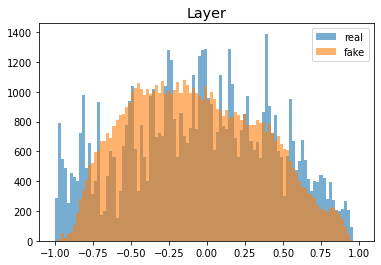

In [1018]:
plt.hist(result_real[:,5].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='real', density=False, range=[-1,1])
plt.hist(result_fake[:,5].flatten().cpu().detach().numpy(), bins=100, alpha=0.6, label='fake', density=False, range=[-1,1])
#plt.yscale('log')
plt.legend()
plt.title("Layer")
plt.show()

In [1019]:
real_smpl = sample_real(1000).permute(0, 2, 1).flatten(0, 1).cpu().detach().numpy()
fake_smpl = sample_fake(1000).permute(0, 2, 1).flatten(0, 1).cpu().detach().numpy()

TypeError: ignored

NameError: ignored

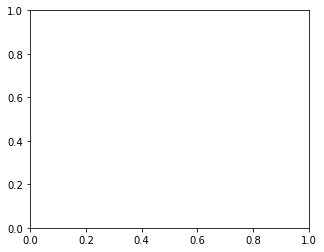

In [301]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.hist2d(real_smpl[:,0], real_smpl[:,1], bins=50, range=[[-1, 1], [-1, 1]]);
plt.title('Real')
plt.xlabel('Energy deposit')
plt.ylabel('Timing')
plt.colorbar();
plt.gca().set_aspect(1)
plt.subplot(122)
plt.title('Fake')
plt.hist2d(fake_smpl[:,0], real_smpl[:,1], bins=50, range=[[-1, 1], [-1, 1]]);
plt.gca().set_aspect(1)
plt.xlabel('Energy deposit')
plt.colorbar();

NameError: ignored

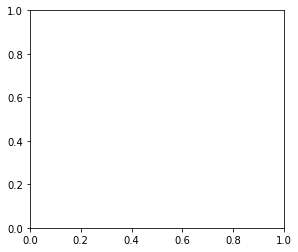

In [302]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist2d(real_smpl[:,1], real_smpl[:,2], bins=50, range=[[-1, 1], [-1, 1]]);
plt.colorbar(); plt.xlabel('time'); plt.ylabel('radius')
plt.subplot(122)
plt.hist2d(fake_smpl[:,1], fake_smpl[:,2], bins=50, range=[[-1, 1], [-1, 1]]);
plt.colorbar(); plt.xlabel('time')

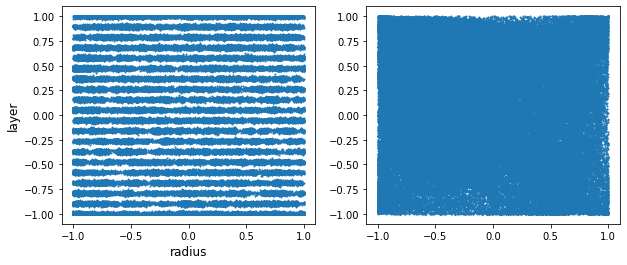

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.scatter(real_smpl[:,3], real_smpl[:,5], s=1)#,  range=[[-1, 1], [-1, 1]]);
plt.xlabel('radius'); plt.ylabel('layer')
plt.subplot(122)
plt.scatter(fake_smpl[:,3], fake_smpl[:,5], s=1)#, bins=50, range=[[-1, 1], [-1, 1]]);

In [ ]:
wire.size

161570

In [ ]:
n_bunches

15.48654375

In [1089]:
_fk = sample_fake(1000, stage, 1).permute(0, 2, 1).detach().cpu().numpy()
_fk.shape
_rl = sample_real(1000, stage, 0).permute(0, 2, 1).detach().cpu().numpy()

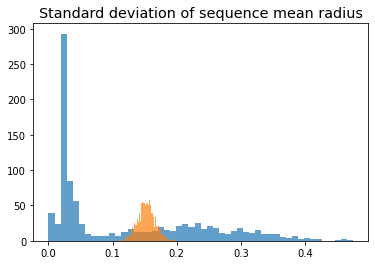

In [1090]:
plt.title('Standard deviation of sequence mean radius')
plt.hist(_rl[:,:,2].std(axis=1), bins=50, alpha=0.7);
plt.hist(_fk[:,:,2].std(axis=1), bins=50, alpha=0.7);

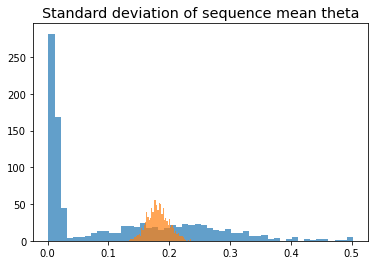

In [1091]:
plt.title('Standard deviation of sequence mean theta')
plt.hist(_rl[:,:,3].std(axis=1), bins=50, alpha=0.7);
plt.hist(_fk[:,:,3].std(axis=1), bins=50, alpha=0.7);

In [1092]:
gen.eval()
compare_N_hits = 5000#1 * chunked.shape[2] // int(n_bunches)
fake_tensor = sample_fake(compare_N_hits // hit_group_size, stage, 1).permute(0, 2, 1).flatten(0, 1)
fake_tensor.shape

torch.Size([4992, 6])

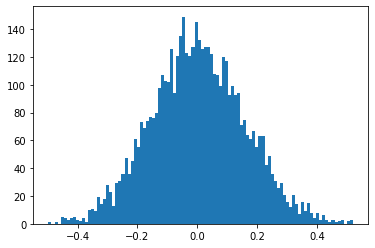

In [1093]:
plt.hist(fake_tensor[:,2].cpu().detach().numpy(), bins=100);

In [1094]:
fake_hits = inv_transform(fake_tensor.T)
fake_hits.shape

(6, 4992)

In [1095]:
fake_wx = fake_hits[2]
fake_wy = fake_hits[3]

In [1096]:
real_tensor = train[0][:compare_N_hits-1]# + torch.randn_like(train[0][:compare_N_hits-1]) * noise_lvl
real_hits = inv_transform(real_tensor.T)
real_hits.shape
real_wx = real_hits[2]
real_wy = real_hits[3]

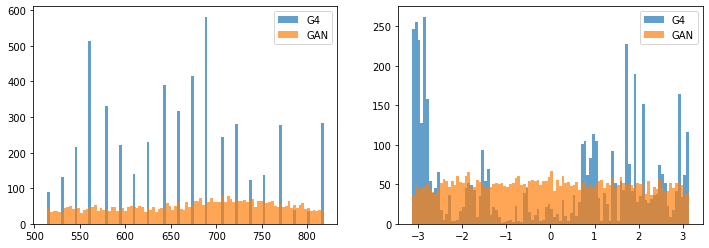

In [1097]:
plt.figure(figsize=(12,4)); plt.subplot(121)
plt.hist(np.sqrt(real_wx**2 + real_wy**2), bins=100, alpha=0.7, label='G4')
plt.hist(np.sqrt(fake_wx**2 + fake_wy**2), bins=100, alpha=0.7, label='GAN'); plt.legend();
plt.subplot(122)
plt.hist(np.arctan2(real_wy, real_wx), bins=100, alpha=0.7, label='G4')
plt.hist(np.arctan2(fake_wy, fake_wx), bins=100, alpha=0.7, label='GAN'); plt.legend();

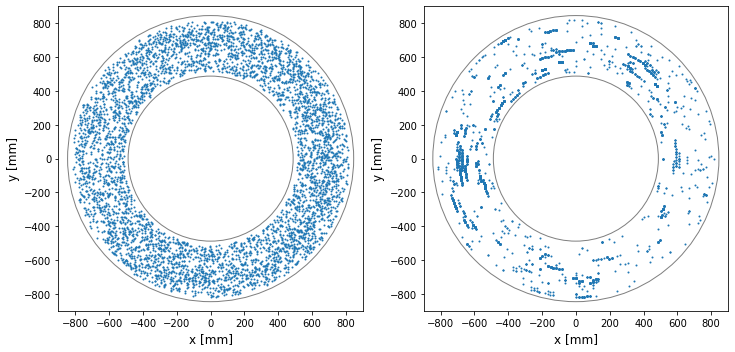

In [1098]:
plt.figure(figsize=(12,6))
plt.subplot(121)
only_walls(plt.gca())
plt.scatter(fake_wx, fake_wy, s=1);
plt.gca().set_aspect(1)

plt.subplot(122)
only_walls(plt.gca())
plt.scatter(real_wx, real_wy, s=1);
plt.gca().set_aspect(1)

In [1099]:
from scipy.spatial.distance import cdist
wire_count = cum_n_wires[-1]

wire_x, wire_y = wire_pos(np.arange(0, wire_count))
def find_closest_wire(x, y):
    pos = np.array([x, y]).T
    wire_pos = np.array([wire_x, wire_y]).T
    dist = cdist(pos, wire_pos, 'euclidean')
    closest = np.argmin(dist, axis=1)
    return closest

#def find_closest_wire(idx):
#    return find_closest_wire(wire_x[idx], wire_y[idx])

torch.Size([320, 6])


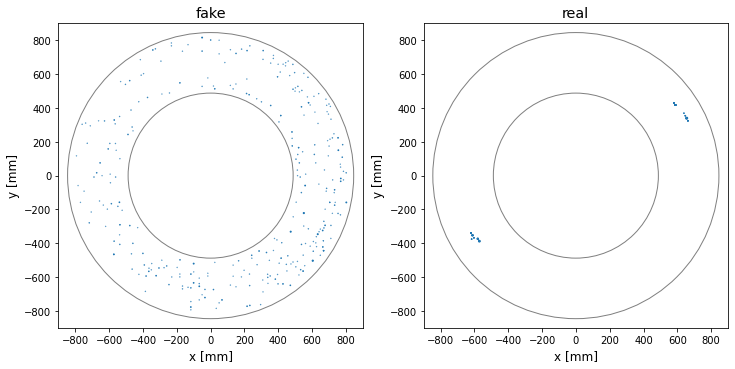

In [1100]:
compare_N_hits = 256#1 * train.shape[1] // int(n_bunches)

fake_tensor = sample_fake(compare_N_hits // hit_group_size + 1, stage, alpha).permute(0, 2, 1).flatten(0, 1)
fake_hits = inv_transform(fake_tensor.T)
print(fake_tensor.shape)
fake_wx = fake_hits[2]
fake_wy = fake_hits[3]
fake_edep = fake_hits[0]

i = np.random.randint(0, wx.size - compare_N_hits-1)
#real_tensor = sample_real(compare_N_hits // hit_group_size, 256, 0).permute(0, 2, 1).flatten(0, 1)#train[:,i:i+compare_N_hits // hit_group_size].flatten(0,1).clone()#
#real_tensor += noise_lvl * torch.randn_like(real_tensor)
# real_hits = inv_transform(real_tensor.T)
# print(real_tensor.shape)
# real_wx = real_hits[2]
# real_wy = real_hits[3]
# real_edep = real_hits[0]

real_wx = wx[i:i+compare_N_hits]
real_wy = wy[i:i+compare_N_hits]
real_edep = np.log10(edep[i:i+compare_N_hits])
real_t = np.log10(t[i:i+compare_N_hits])

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('fake')
only_walls(plt.gca())
fake_wire_idx = find_closest_wire(fake_wx, fake_wy)
plt.scatter(wire_x[fake_wire_idx], wire_y[fake_wire_idx], s=0.1+np.power(10, fake_edep) * 100);
plt.gca().set_aspect(1)

plt.subplot(122)
plt.title('real')
only_walls(plt.gca())
real_wire_idx = find_closest_wire(real_wx, real_wy)
plt.scatter(wire_x[real_wire_idx], wire_y[real_wire_idx], s=0.1+np.power(10, real_edep) * 100);
plt.gca().set_aspect(1)
plt.savefig('GAN_vs_G4_cdc.png', dpi=120)

### Grid of samples for a reduced region of phase space

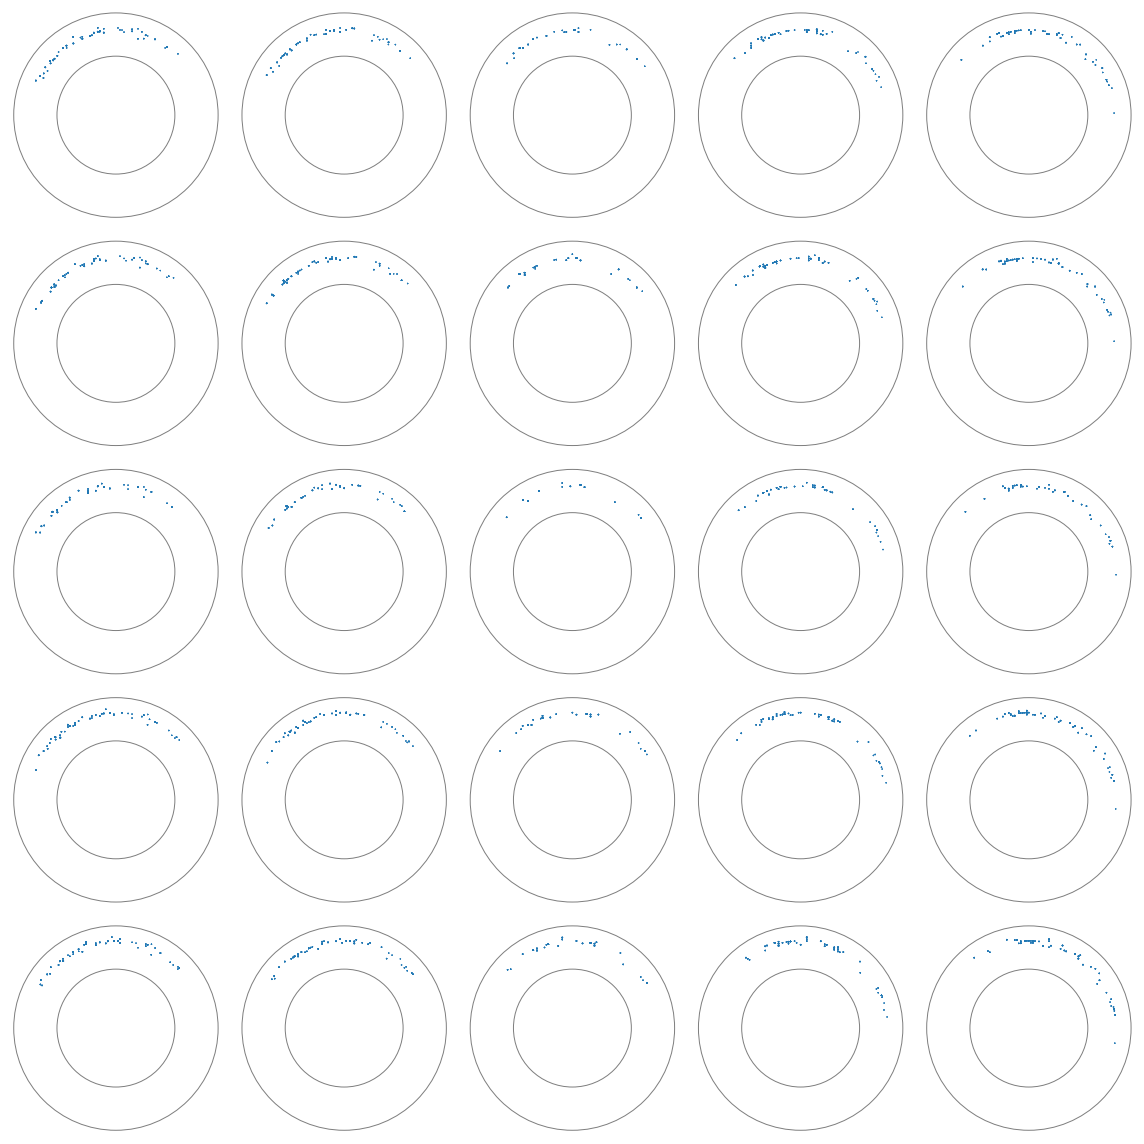

In [1057]:
# Select two latent space dimensions and explore the range
dim0 = 31
dim1 = 35
step = 0.2
plt.figure(figsize=(16,16))

nrows = int(1 / step)
ncols = int(1 / step)

def get_sample(N_hits, latent_pos):
    fake_tensor = gen(latent_pos, stage, 1).permute(0, 2, 1).flatten(0, 1)
    fake_hits = inv_transform(fake_tensor.T)
    fake_wx = fake_hits[2]
    fake_wy = fake_hits[3]
    fake_edep = fake_hits[0]
    return fake_wx, fake_wy, fake_edep

compare_N_hits = 400#1 * chunked.shape[2] // int(n_bunches)
latent_pos = torch.zeros((compare_N_hits // hit_group_size, latent_dims, 1), device='cuda')
    
for i in range(nrows):
    for j in range(ncols):
        plt.subplot(nrows, ncols, i*nrows + j + 1, frameon=False)
        
        
        latent_pos[:,dim0] = i / (nrows-1) * 4 - 2
        latent_pos[:,dim1] = j / (ncols-1) * 4 - 2
        _wx, _wy, _edep = get_sample(compare_N_hits, latent_pos)
        
        only_walls(plt.gca())
        plt.xlabel('')
        plt.ylabel('')
        plt.gca().axis('off')
        _idx = find_closest_wire(_wx, _wy)
        plt.scatter(wire_x[_idx], wire_y[_idx], s=np.power(10, _edep) * 500);
    
    
plt.tight_layout()
plt.savefig('GAN_gen_grid.png', dpi=120)

In [ ]:
torch.save(gen, "progen_10k_its_into_128_stage.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Gen256Ups. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvTransposeEQ. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type PixelwiseNorm. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
torch.save(disc, "prodisc_10k_its_into_128_stage.pt")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Disc256Ups. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvEQ. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MBStdDev. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
!wget http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/prodisc_10k_its_into_128_stage.pt http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/progen_10k_its_into_128_stage.pt

--2020-07-15 08:55:04--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/prodisc_10k_its_into_128_stage.pt
Resolving www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)... 146.179.108.103, 2a0c:5bc0:88:111:216:3eff:fe7f:177
Connecting to www.hep.ph.ic.ac.uk (www.hep.ph.ic.ac.uk)|146.179.108.103|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809021 (1.7M)
Saving to: ‘prodisc_10k_its_into_128_stage.pt’

prodisc_10k_its_int 100%[===================>]   1.72M  2.91MB/s    in 0.6s    

2020-07-15 08:55:05 (2.91 MB/s) - ‘prodisc_10k_its_into_128_stage.pt’ saved [1809021/1809021]

--2020-07-15 08:55:05--  http://www.hep.ph.ic.ac.uk/~md618/noiseGAN/progen_10k_its_into_128_stage.pt
Reusing existing connection to www.hep.ph.ic.ac.uk:80.
HTTP request sent, awaiting response... 200 OK
Length: 817261 (798K)
Saving to: ‘progen_10k_its_into_128_stage.pt’

progen_10k_its_into 100%[===================>] 798.11K  --.-KB/s    in 0.007s  

2020-07-15 08:55:06 (115 MB/s) - ‘progen_10k_its_into_

In [ ]:
_disc = torch.load("/content/prodisc_10k_its_into_128_stage.pt")

In [ ]:
_disc

Disc256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (from256): ConvEQ(6, 6, kernel_size=(1,), stride=(1,))
  (conv1_1): ConvEQ(6, 12, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (from128): ConvEQ(6, 12, kernel_size=(1,), stride=(1,))
  (conv2_1): ConvEQ(12, 24, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (from64): ConvEQ(6, 24, kernel_size=(1,), stride=(1,))
  (conv3_1): ConvEQ(24, 48, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (from32): ConvEQ(6, 48, kernel_size=(1,), stride=(1,))
  (conv4_1): ConvEQ(48, 96, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (from16): ConvEQ(6, 96, kernel_size=(1,), stride=(1,))
  (conv5_1): ConvEQ(96, 192, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool5): AvgPool1d

In [ ]:
disc = _disc

In [ ]:
_gen = torch.load("/content/progen_10k_its_into_128_stage.pt")

In [ ]:
_gen

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv0): ConvTransposeEQ(128, 128, kernel_size=(4,), stride=(1,))
  (bn0): PixelwiseNorm()
  (conv1_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1_1): PixelwiseNorm()
  (to4): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups1): Upsample(scale_factor=2.0, mode=nearest)
  (conv2_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2_1): PixelwiseNorm()
  (to8): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups2): Upsample(scale_factor=2.0, mode=nearest)
  (conv3_1): ConvTransposeEQ(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3_1): PixelwiseNorm()
  (to16): ConvTransposeEQ(64, 6, kernel_size=(1,), stride=(1,))
  (ups3): Upsample(scale_factor=2.0, mode=nearest)
  (conv4_1): ConvTransposeEQ(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4_1): PixelwiseNorm()
  (to32): ConvTransposeEQ(32, 6, kernel_size=(1,), stride

In [ ]:
gen = _gen

### Radius distribution

In [ ]:
sample_real(10, stage, 0).permute(0, 2, 1).shape

torch.Size([10, 256, 6])

In [1035]:
compare_N_hits = wx.size#chunked.shape[2]
print(compare_N_hits)

fake_tensor = sample_fake(compare_N_hits // hit_group_size, stage, 1).permute(0, 2, 1).flatten(0, 1)
fake_hits = inv_transform(fake_tensor.T)
fake_wx = fake_hits[2]
fake_wy = fake_hits[3]
fake_edep = fake_hits[0]
fake_t = fake_hits[1]

fake_wire_idx = find_closest_wire(fake_wx, fake_wy)


#real_tensor = train[:4,:compare_N_hits // 4].flatten(0, 1)
#real_tensor = real_tensor.clone()
#real_tensor += 0.015 * torch.randn_like(real_tensor)
#real_hits = inv_transform(real_tensor.T)
real_wx = wx[:compare_N_hits]
real_wy = wy[:compare_N_hits]
real_edep = np.log10(edep[:compare_N_hits])
real_t = np.log10(t[:compare_N_hits])

real_wire_idx = find_closest_wire(real_wx, real_wy)

160193


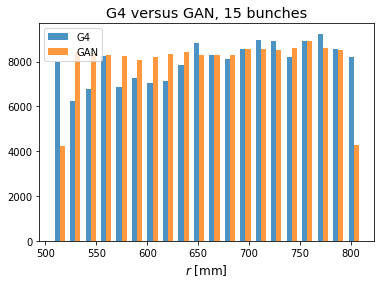

In [1036]:
plt.figure(figsize=(6, 4))
_r_real = np.sqrt(wire_x[real_wire_idx]**2 + wire_y[real_wire_idx]**2)
_r_fake = np.sqrt(wire_x[fake_wire_idx]**2 + wire_y[fake_wire_idx]**2)

counts, bins = np.histogram(_r_real, bins=20)
plt.bar(bins[:-1] - 2.5, counts / (256 // stage), width=5, label='G4', alpha=0.8)
counts, bins = np.histogram(_r_fake, bins=20)
plt.bar(bins[:-1] + 2.5, counts, width=5, label='GAN', alpha=0.8)
#plt.hist(_r_real, bins=20, alpha=0.7, label='real');
#plt.hist(_r_fake, bins=20, alpha=0.7, label='fake');

plt.legend();
plt.title('G4 versus GAN, 15 bunches')
plt.xlabel('$r$ [mm]')
plt.savefig('radius_comp.png', dpi=120)

### Angular distribution on the last 3 layers to see potential square->circle transformation bias

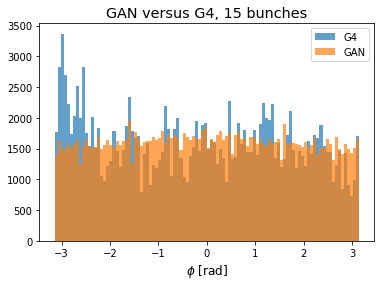

In [1037]:
plt.figure(figsize=(6, 4))

_phi_real = np.arctan2(wire_y[real_wire_idx], wire_x[real_wire_idx])
_phi_fake = np.arctan2(wire_y[fake_wire_idx], wire_x[fake_wire_idx])
plt.hist(_phi_real, bins=100, alpha=0.7, label='G4', density=False)
plt.hist(_phi_fake, bins=100, alpha=0.7, label='GAN', density=False);

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'$\phi$ [rad]')
plt.savefig('phi_comp.png', dpi=120)

### Energy, time

Text(0.5, 0, 'log10(Energy deposit [MeV])')

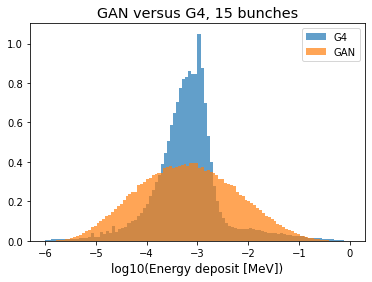

In [1038]:
plt.figure(figsize=(6, 4))

plt.hist(real_edep, bins=100, alpha=0.7, label='G4', density=True)
plt.hist(fake_edep, bins=100, alpha=0.7, label='GAN', density=True);

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'log10(Energy deposit [MeV])')
#plt.savefig('phi_comp.png', dpi=120)

Text(0.5, 0, 'log10(t [ns])')

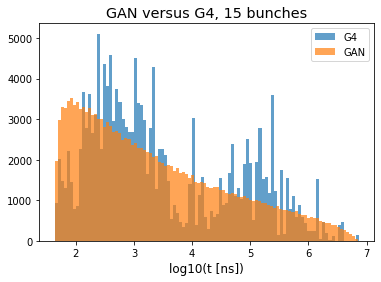

In [1039]:
plt.figure(figsize=(6, 4))

plt.hist(real_t, bins=100, alpha=0.7, label='G4')
plt.hist(fake_t, bins=100, alpha=0.7, label='GAN');

plt.title('GAN versus G4, 15 bunches')
plt.legend();
plt.xlabel(r'log10(t [ns])')


#plt.savefig('phi_comp.png', dpi=120)

### Number of consecutive activated / empty wires

In [1040]:
num_layers = 20

def consecutive_hits(wire_idx):
    layer, wire = wire_abs_to_rel(wire_idx)
    sum_consec = np.zeros(num_layers)
    for i in range(num_layers):
        l_w = wire[layer == i]
        dist_mat = cdist(l_w[:, np.newaxis], l_w[:, np.newaxis])
        # !!! NOTE: I changed distance threshold to zero to see hit counts on the same wire
        sum_consec[i] = np.sum(dist_mat <= 1) / 2 / l_w.size
        #print(l_w.size, (dist_mat <= 1).shape)
        #print("avg dist at", i, " : ", dist_mat.mean())
        #print(dist_mat)
    return sum_consec
    
#plt.hist(sum_consec, range=[0,num_layers], bins=num_layers);

In [1041]:
compare_N_hits = 1 * wx.size // int(n_bunches)

fake_tensor = sample_fake(compare_N_hits // hit_group_size, stage, 1).permute(0, 2, 1).flatten(0, 1)
fake_hits = inv_transform(fake_tensor.T)
fake_wx = fake_hits[2]
fake_wy = fake_hits[3]
fake_edep = fake_hits[0]

fake_wire_idx = find_closest_wire(fake_wx, fake_wy)


real_wx = wx[:compare_N_hits]
real_wy = wy[:compare_N_hits]
real_edep = np.log10(edep[:compare_N_hits])
real_t = np.log10(t[:compare_N_hits])

real_wire_idx = find_closest_wire(real_wx, real_wy)

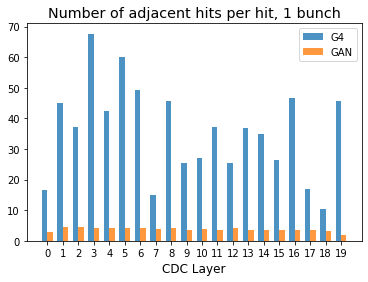

In [1042]:
plt.figure(figsize=(6, 4))
#plt.subplot(121)

real_consec = consecutive_hits(real_wire_idx)
#real_consec
plt.bar(np.arange(num_layers) - 0.175, real_consec, width=0.35, label='G4', alpha=0.8);
plt.xticks(np.arange(num_layers));

fake_consec = consecutive_hits(fake_wire_idx)
#fake_consec
plt.bar(np.arange(num_layers) + 0.175, fake_consec, width=0.35, label='GAN', alpha=0.8);
plt.xticks(np.arange(num_layers));

plt.legend();
plt.xlabel("CDC Layer")
plt.title("Number of adjacent hits per hit, 1 bunch")

plt.savefig('adjacent_comp.png', dpi=120)

In [1043]:
_total_consec_real = 0
_total_consec_fake = 0
for i in range(num_layers):
    l, w = wire_abs_to_rel(real_wire_idx)
    n_consec = (cdist(w[l == i][:,np.newaxis], w[l == i][:,np.newaxis]) <= 1.).sum()
    _total_consec_real += n_consec
    
    l, w = wire_abs_to_rel(fake_wire_idx)
    n_consec = (cdist(w[l == i][:,np.newaxis], w[l == i][:,np.newaxis]) <= 1.).sum()
    _total_consec_fake += n_consec
print("total real:", _total_consec_real, "  fake:", _total_consec_fake)

total real: 850383   fake: 80676


### Number of empty/full wires per layer

In [1044]:
num_layers = 20

def occupancy(wire_idx):
    layer, wire = wire_abs_to_rel(wire_idx)
    ret = np.zeros(num_layers)
    for i in range(num_layers):
        l_w = wire[layer == i]
        wires_in_layer = cum_n_wires[i+1] - cum_n_wires[i]
        empty = wires_in_layer - np.unique(l_w).size
        ret[i] = 1 - empty / wires_in_layer
        #sum_consec[i] = (dist_mat <= 1).sum() / 2 / l_w.size
        #print(dist_mat)
    return ret
    
#plt.hist(sum_consec, range=[0,num_layers], bins=num_layers);

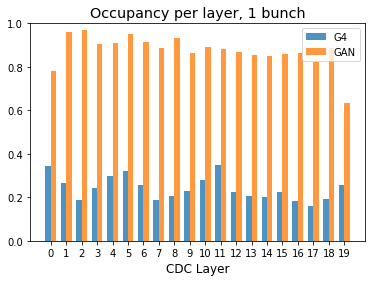

In [1045]:
plt.figure(figsize=(6, 4))
#plt.subplot(121)

real_empty = occupancy(real_wire_idx)
#real_consec
plt.bar(np.arange(num_layers) - 0.175, real_empty, width=0.35, label='G4', alpha=0.8);
plt.xticks(np.arange(num_layers));

fake_empty = occupancy(fake_wire_idx)
#fake_consec
plt.bar(np.arange(num_layers) + 0.175, fake_empty, width=0.35, label='GAN', alpha=0.8);
plt.xticks(np.arange(num_layers));

plt.legend();
plt.xlabel("CDC Layer")
plt.title("Occupancy per layer, 1 bunch")

plt.ylim(0, 1);
plt.savefig('fraction_empty_comp.png', dpi=120)

In [972]:
edep_per_wire = np.zeros(cum_n_wires[-1])
for i in range(cum_n_wires[-1]):
    edep_per_wire[i] = np.sum(real_edep[real_wire_idx == i])

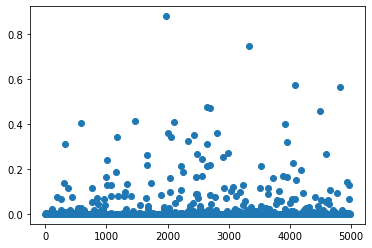

In [973]:
plt.scatter(np.arange(cum_n_wires[-1])[edep_per_wire!=0], np.power(10, edep_per_wire)[edep_per_wire!=0]);

In [974]:
edep_per_wire = np.zeros(cum_n_wires[-1])
for i in range(cum_n_wires[-1]):
    edep_per_wire[i] = np.sum(fake_edep[fake_wire_idx == i])

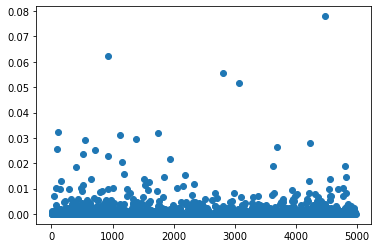

In [975]:
plt.scatter(np.arange(cum_n_wires[-1])[edep_per_wire!=0], np.power(10, edep_per_wire)[edep_per_wire!=0]);

## Nearest neighbors

In [1657]:
chunked.detach().cpu().numpy().shape

(6, 128, 2502)

In [1658]:
# Generate N samples and find their nearest neighbors in the training set
N = 10
fake_tensor = sample_fake(N, stage, 1).permute(0, 2, 1)
print(fake_tensor.shape)

torch.Size([10, 128, 6])


ValueError: ignored

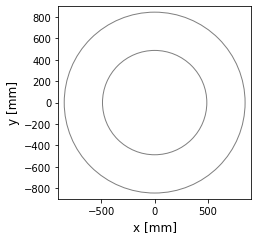

In [1659]:
from scipy.spatial.distance import euclidean

def nearest_neighbor(fake):
    real = chunked.permute(2, 1, 0)
    #print(real.shape)
    #print((real - fake[np.newaxis,:]).shape)
    dist = torch.sqrt((real[:, :, 2:] - fake[np.newaxis,:][:, :, 2:])**2).mean(axis=(1,2))
    #print(dist.shape)
    min = torch.argmin(dist)
    #print(min.shape, min)
    return real[min]
    


plt.figure(figsize=(20, 8))
#plt.subplots(2, 3)
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.gca().set_aspect(1)
    neighb = nearest_neighbor(fake_tensor[i])

    only_walls(plt.gca())
    _pts = inv_transform(neighb).T
    #print(_pts.shape)
    plt.scatter(_pts[2], _pts[3], s=np.power(10, _pts[0]) * 100, alpha=0.7, label='G4');
    _fk = inv_transform(fake_tensor[i]).T
    
    _fk_idx = find_closest_wire(_fk[2], _fk[3])
    plt.scatter(wire_x[_fk_idx], wire_y[_fk_idx], s=np.power(10, _fk[0]) * 100, alpha=0.7, label='GAN');
    if (i==0):
        plt.legend()
    plt.ylabel('')
    plt.xlabel('')
    

plt.savefig('GAN_vs_G4_nearest_neighbor_1.png', dpi=120)

## Old

In [ ]:

gen

Gen256Ups(
  (act): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv0): ConvTransposeEQ(128, 128, kernel_size=(4,), stride=(1,))
  (bn0): PixelwiseNorm()
  (conv1_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1_1): PixelwiseNorm()
  (to4): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups1): Upsample(scale_factor=2.0, mode=nearest)
  (conv2_1): ConvTransposeEQ(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2_1): PixelwiseNorm()
  (to8): ConvTransposeEQ(128, 6, kernel_size=(1,), stride=(1,))
  (ups2): Upsample(scale_factor=2.0, mode=nearest)
  (conv3_1): ConvTransposeEQ(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3_1): PixelwiseNorm()
  (to16): ConvTransposeEQ(64, 6, kernel_size=(1,), stride=(1,))
  (ups3): Upsample(scale_factor=2.0, mode=nearest)
  (conv4_1): ConvTransposeEQ(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4_1): PixelwiseNorm()
  (to32): ConvTransposeEQ(32, 6, kernel_size=(1,), stride

In [ ]:

disc

Disc200(
  (main): Sequential(
    (0): Conv1d(5, 32, kernel_size=(6,), stride=(2,), padding=(2,))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(3,), padding=(5,))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv1d(128, 256, kernel_size=(4,), stride=(4,), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv1d(256, 1, kernel_size=(5,), stride=(1,), bias=False)
    (9): Sigmoid()
  )
)

---

### Old stuff when wires was one of the features

In [ ]:
fake_wire = np.round(fake_hits[2]).astype(int)

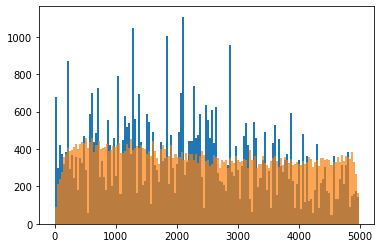

In [ ]:
plt.hist(wire[:compare_N_hits], bins=150);
plt.hist(fake_wire, bins=150, alpha=0.7);

In [ ]:
# /!\ Careful memory hungry!
# Let's do it in N steps
N_steps = 8
fk_wx = np.zeros_like(fake_wire)
fk_wy = np.zeros_like(fake_wire)
for i in range(N_steps):
    start = i * fake_wire.size // N_steps
    end = (i+1) * fake_wire.size // N_steps
    print(start, end)
    fk_wx_step, fk_wy_step = wire_pos(fake_wire[start:end])
    fk_wx[start:end] = fk_wx_step
    fk_wy[start:end] = fk_wy_step
    

print(fk_wx)

0 6725
6725 13450
13450 20175
20175 26900
26900 33625
33625 40350
40350 47075
47075 53800
[ 558  292 -627 ...  165 -561  359]


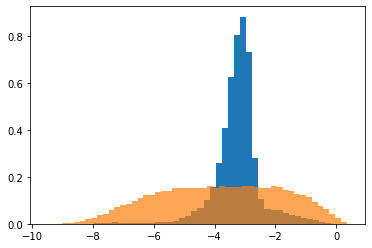

In [ ]:
plt.hist(np.log10(edep), bins=50, density=True);
plt.hist(fake_hits[0], bins=50, alpha=0.7, density=True);

In [ ]:
fk_edep = np.power(10, fake_hits[0])

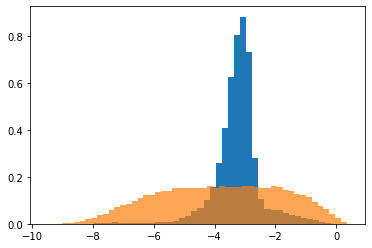

In [ ]:
plt.hist(np.log10(edep), bins=50, density=True);
plt.hist(np.log10(fk_edep), bins=50, alpha=0.7, density=True);

In [ ]:
n_hits_per_bunch = data.size // n_bunches
n_hits_per_bunch

10437.0

NameError: name 'fk_wx' is not defined

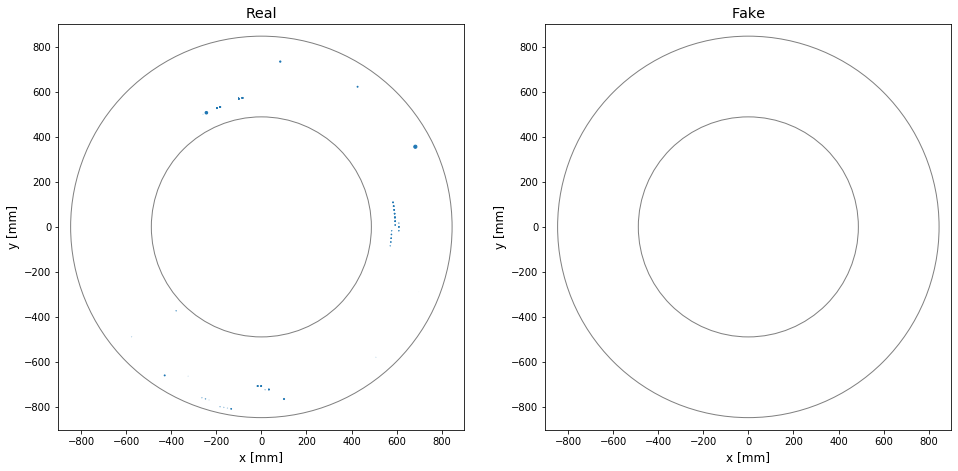

In [ ]:
plt.figure(figsize=(16, 8))

N = compare_N_hits // 10

plt.subplot(121)
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)
ax.set_aspect(1)
plt.title('Real')
plt.scatter(wx[:N], wy[:N], s=edep[:N] * 100, cmap='tab10');


plt.subplot(122)
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)
ax.set_aspect(1)
plt.title('Fake')
plt.scatter(fk_wx[:N], fk_wy[:N], s=fk_edep[:N] * 100, cmap='tab10');


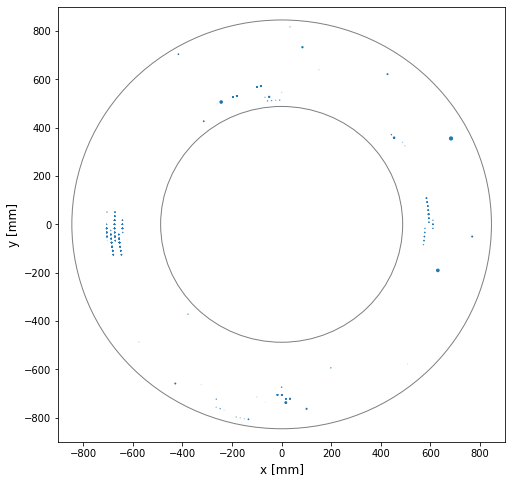

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
#grid_and_walls(ax)
only_walls(ax)

plt.scatter(wx[:N], wy[:N], s=edep[:N] * 100, cmap='tab10');

In [ ]:
for i in range(int(n_bunches+1)):
    print("Hits in bunch %02d:  %d" % (i, event_id[(event_id >= i * 16e6) * (event_id < (i+1) * 16e6)].size))

Hits in bunch 00:  11800
Hits in bunch 01:  9668
Hits in bunch 02:  8952
Hits in bunch 03:  13542
Hits in bunch 04:  13256
Hits in bunch 05:  11393
Hits in bunch 06:  8915
Hits in bunch 07:  9114
Hits in bunch 08:  8755
Hits in bunch 09:  10619
Hits in bunch 10:  9838
Hits in bunch 11:  11383
Hits in bunch 12:  10898
Hits in bunch 13:  8393
Hits in bunch 14:  11094
Hits in bunch 15:  3950


In [ ]:
sample_real(10)

tensor([[ 0.2202,  0.7926, -0.7123],
        [ 0.2980,  0.7926, -0.7119],
        [ 0.3027,  0.7926, -0.7962],
        [ 0.2196,  0.7926, -0.8756],
        [ 0.3102,  0.7926, -0.8760],
        [ 0.3729,  0.7926, -0.7966],
        [ 0.3674,  0.7926, -0.7962],
        [ 0.3334,  0.7926, -0.8756],
        [ 0.3206,  0.7926, -0.8760],
        [ 0.3579,  0.7926, -0.7966]])

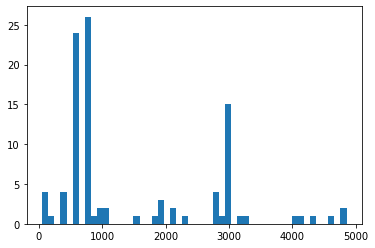

In [ ]:
plt.hist(inv_transform(sample_real(100))[:,2], bins=50);

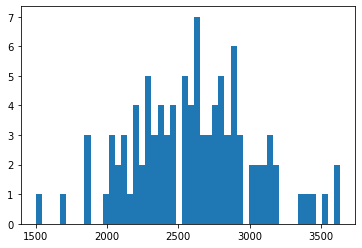

In [ ]:
plt.hist(inv_transform(sample_fake(100))[:,2], bins=50);

# 

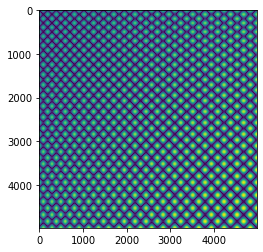

In [ ]:
# Calculate all wire distances and store in a tensor
from scipy.spatial.distance import cdist

distances = cdist(wire_x[:,np.newaxis], wire_x[:,np.newaxis])

plt.imshow(distances)

In [ ]:
_a = torch.tensor([1.5, 2.0, 1.5, 1.5], requires_grad=True)
_b = torch.pairwise_distance(_a.unsqueeze(0).T, _a).mean()

_b.backward()
_a.grad

tensor([-0.3943,  1.1830, -0.3943, -0.3943])